In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import ldc.io.hdf5 as h5io
from ldc.lisa.noise import get_noise_model  

In [3]:
plt.rcParams.update({
    # Font
    'font.family':       'serif',
    'font.serif':        ['Latin Modern Roman'],
    'font.size':         10,         # base font size
    'mathtext.fontset':   'cm',               # or 'stix'
    'mathtext.rm':        'serif',
    # Axes
    'axes.titlesize':    12,
    'axes.labelsize':    11,
    'axes.linewidth':    1.0,
    
    # Ticks
    'xtick.direction':   'in',
    'ytick.direction':   'in',
    'xtick.top':         True,
    'ytick.right':       True,
    'xtick.labelsize':   10,
    'ytick.labelsize':   10,
    
    # Grid (if you ever want one)
    'axes.grid':         False,
    'grid.linestyle':    '--',
    'grid.linewidth':    0.5,
    'grid.color':        '0.8',
    
    # Legend
    'legend.frameon':    False,
    'legend.fontsize':   10,
    
    # Figure
    'figure.figsize':    (8, 6),    # default figure size
    'figure.dpi':        300,       # high‑res
})

In [8]:
def extract_model_info(filename):
    """
    Extracts the model name and version from the filename.
    Example:
        'resolved_Model1_0_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.0'
        'resolved_Model1_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.1'
    """
    # Regular expression to capture 'Model' followed by a number, an underscore, and another number
    match = re.search(r'resolved_(Model)(\d+)_(\d+)_MW', filename)
    if match:
        model_prefix = match.group(1)      # 'Model'
        model_number = match.group(2)      # e.g., '1'
        model_version = match.group(3)     # e.g., '0', '1'
        # Format as 'Model 1.0', 'Model 1.1', etc.
        formatted_model = f"{model_prefix} {model_number}.{model_version}"
        return formatted_model
    else:
        return 'Unknown'
def process_h5_file(filepath):
    """
    Processes a single .h5 file and extracts the necessary parameters.
    Returns a pandas DataFrame with the extracted data and model information.
    """
    # Extract the model from the filename
    filename = os.path.basename(filepath)
    model = extract_model_info(filename)
    
    cats, units = h5io.load_array(filepath, 'cat')
    
    data = {
        'Name': cats['Name'],
        'Frequency': cats['Frequency'],
        'Amplitude': cats['Amplitude'],
        'FrequencyDerivative': cats['FrequencyDerivative'],
        'SNR': np.sqrt(cats['snr2']),
        'Eccentricity': cats['Eccentricity'],
        'Inclination': cats['Inclination'],
        'Polarization': cats['Polarization'],
        'EclipticLatitude': cats['EclipticLatitude'],
        'EclipticLongitude': cats['EclipticLongitude'],
        'InitialPhase': cats['InitialPhase'],
        'Model': model 
    }
    
    df = pd.DataFrame(data)
    
    return df
def compile_data_from_folder(folder_path):
    """
    Compiles data from all .h5 files in the specified folder into a single DataFrame.
    """
    all_data = []
    
    # List all .h5 files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.h5') and filename.startswith('resolved_'):
            filepath = os.path.join(folder_path, filename)
            try:
                df = process_h5_file(filepath)
                all_data.append(df)
                print(f"Processed file: {filename}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    
    if all_data:
        # Concatenate all DataFrames
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df
    else:
        print("No .h5 files found or no data extracted.")
        return pd.DataFrame()  # Return empty DataFrame if no data

In [9]:
resolved_folder_path = '/Users/irwin/Documents/GitHub/lisa-ml/data/resolved_binaries/'
resolved_df = compile_data_from_folder(resolved_folder_path)
resolved_df['Class'] = resolved_df['Name'].str.extract(r'MW_(DWD|NSWD)')
selected_features = ['Frequency', 'Amplitude', 'FrequencyDerivative', 'SNR', 'Eccentricity']

resolved_df = resolved_df.dropna(subset=selected_features + ['Class'])

# Encode labels: DWD=0, NSWD=1
label_encoder = LabelEncoder()
resolved_df['Class'] = label_encoder.fit_transform(resolved_df['Class'])
resolved_df['Frequency_mHz'] = resolved_df['Frequency'] * 1000
resolved_df['FrequencyDerivative_log10'] = np.log10(resolved_df['FrequencyDerivative'])
resolved_df['EclipticLatitude_sin'] = np.sin(resolved_df['EclipticLatitude'])
resolved_df['Amplitude_log10'] = np.log10(resolved_df['Amplitude'])
resolved_df['Inclination_cos'] = np.cos(resolved_df['Inclination'])

cols_to_remove = ['Frequency', 'FrequencyDerivative', 'EclipticLatitude', 'Amplitude', 'Inclination']
resolved_df.drop(columns=cols_to_remove, inplace=True)

Processed file: resolved_Model2_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5
Processed file: resolved_Model2_2_MW_DWDs_aa2CE_NSWDs_aa2CE_akick.h5
Processed file: resolved_Model3_1_MW_DWDs_agCE_NSWDs_agCE_vkick.h5
Processed file: resolved_Model3_0_MW_DWDs_agCE.h5
Processed file: resolved_Model1_1_MW_DWDs_aaCE_NSWDs_aaCE_vkick.h5
Processed file: resolved_Model1_0_MW_DWDs_aaCE.h5
Processed file: resolved_Model1_2_MW_DWDs_aaCE_NSWDs_aaCE_akick.h5
Processed file: resolved_Model2_4_MW_DWDs_aa2CE_NSWDs_aa2CE_bkick.h5
Processed file: resolved_Model1_4_MW_DWDs_aaCE_NSWDs_aaCE_bkick.h5
Processed file: resolved_Model2_3_MW_DWDs_aa2CE_NSWDs_aa2CE_hkick.h5
Processed file: resolved_Model1_3_MW_DWDs_aaCE_NSWDs_aaCE_hkick.h5


In [22]:
selected_features = [
    'Frequency_mHz', 
    'Amplitude_log10', 
    'FrequencyDerivative_log10', 
    'SNR', 
    'Eccentricity',
    'EclipticLatitude_sin',
    'Inclination_cos',
    'Polarization',
    'EclipticLongitude',
    'InitialPhase'
]

X = resolved_df[selected_features]
y = resolved_df['Class'] 

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

In [23]:
xgb_clf = xgb.XGBClassifier(random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='roc_auc',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [24]:
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba))

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26682
           1       0.99      0.83      0.90       314

    accuracy                           1.00     26996
   macro avg       0.99      0.92      0.95     26996
weighted avg       1.00      1.00      1.00     26996

ROC AUC Score: 0.9941559876956101


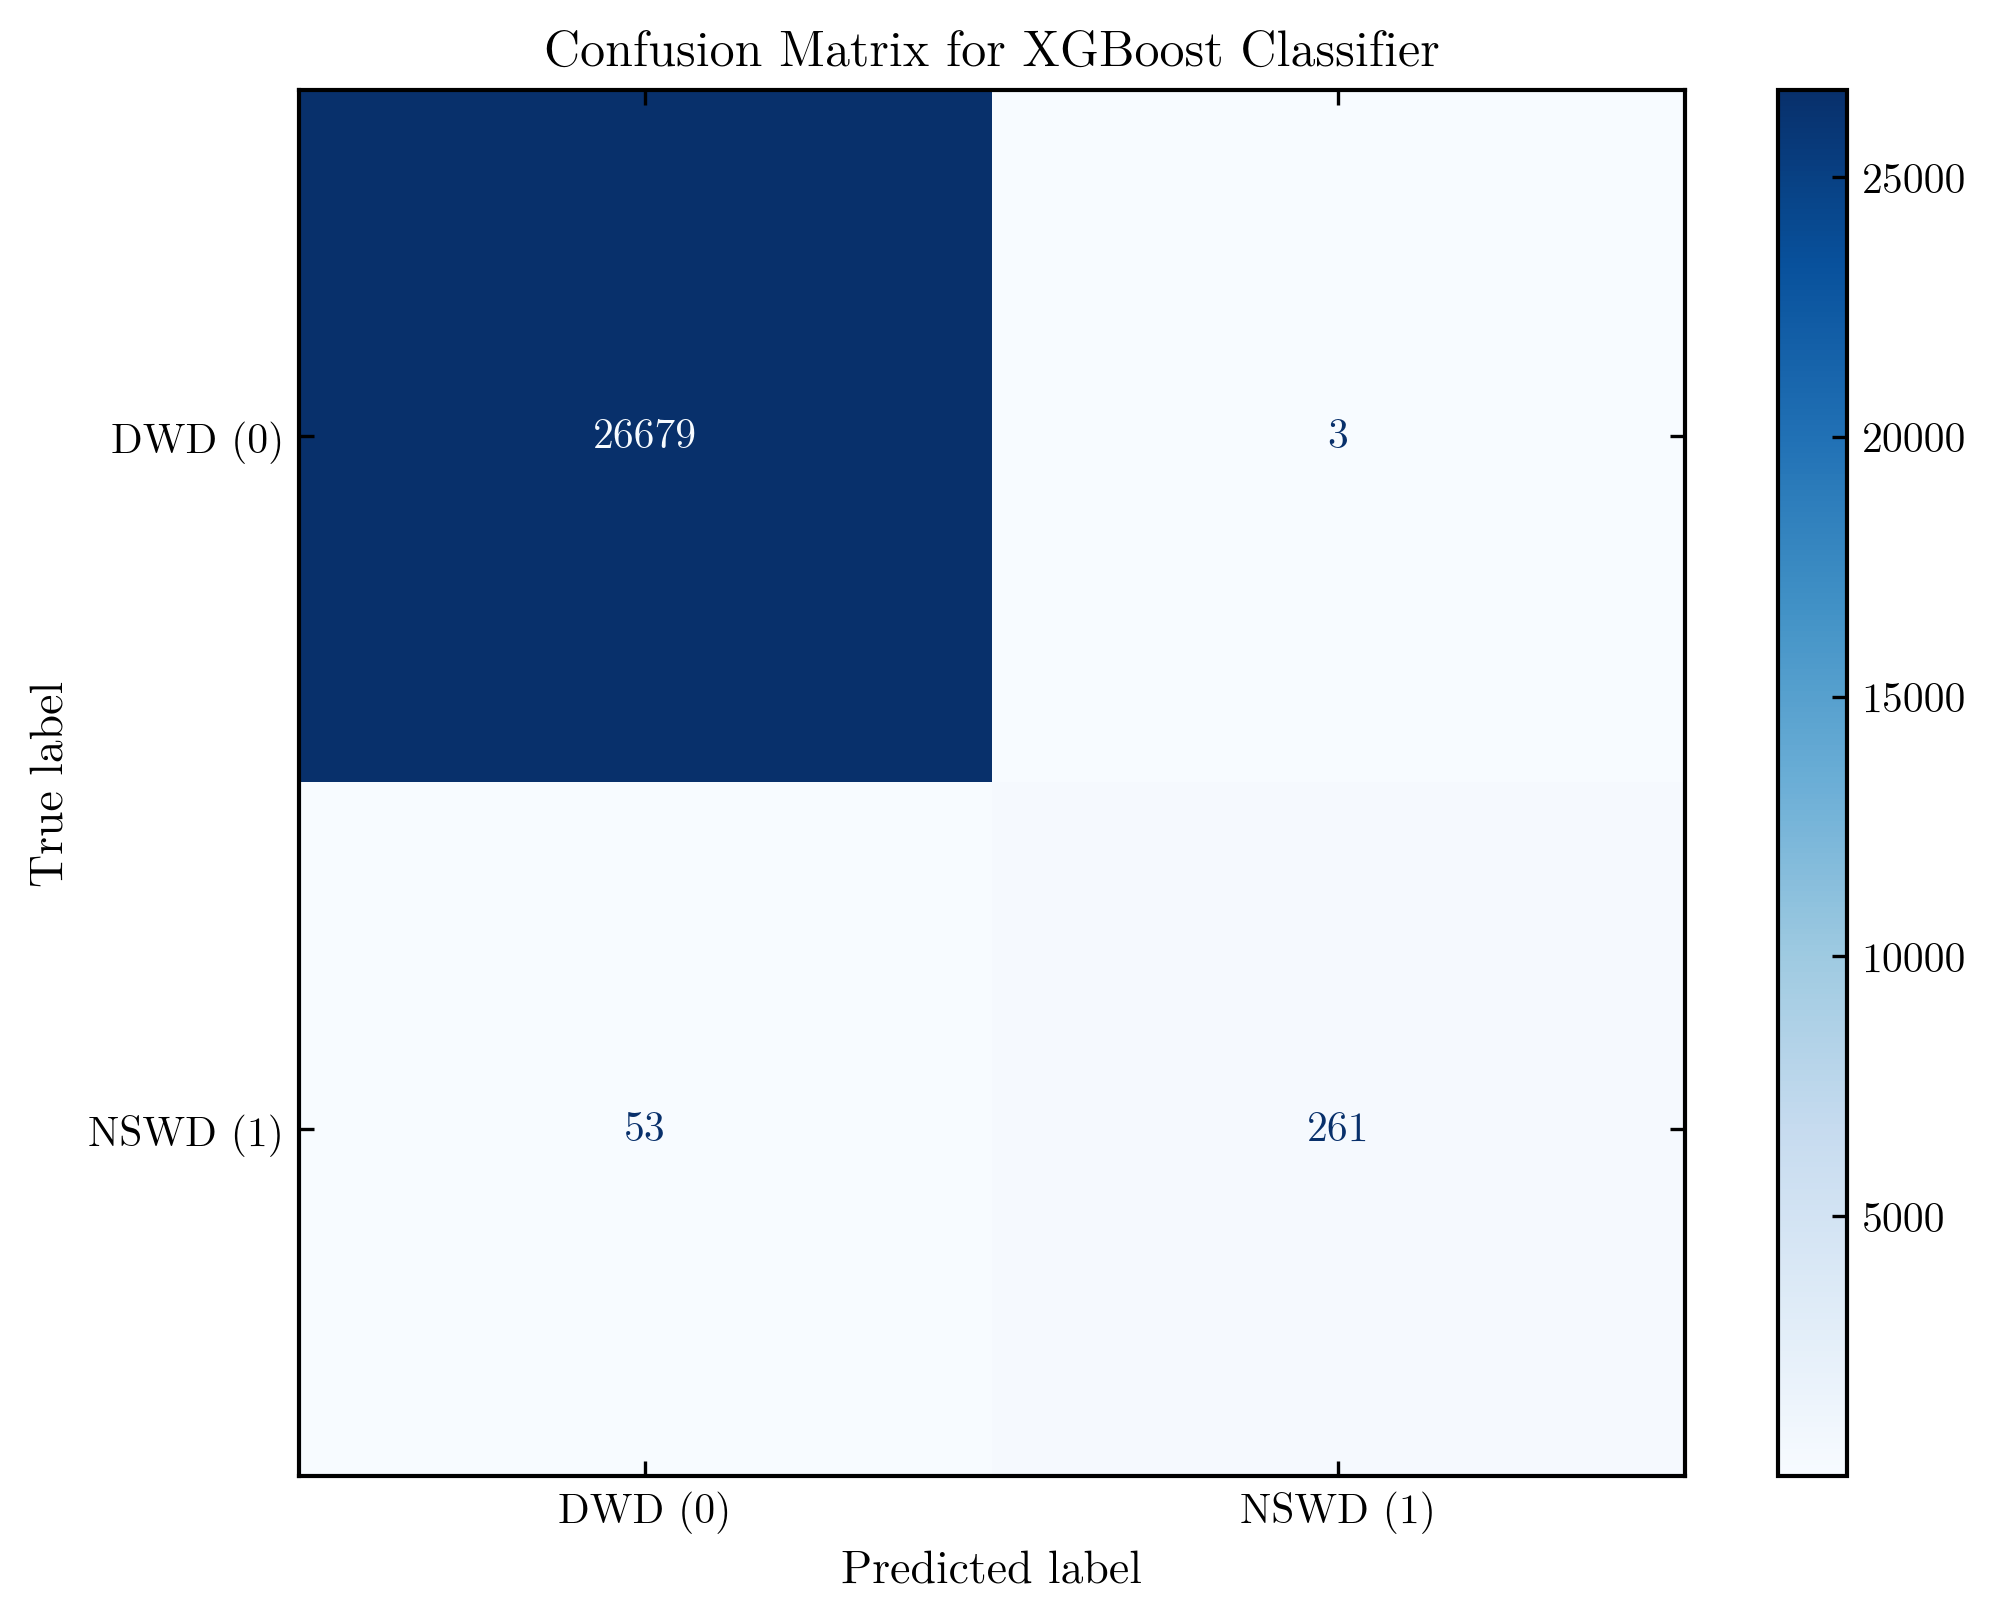

In [25]:
cm = confusion_matrix(y_val, y_pred, labels=[0, 1])  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DWD (0)', 'NSWD (1)'])

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for XGBoost Classifier")
plt.grid(False)
plt.show()

In [26]:
Tobs     = 4*ASTRONOMICAL_YEAR                # Duration of the measurement
f_range        = np.linspace(1e-4,1e-1,1000)        # The frequency array
lisa_noise = get_noise_model('SciRDv1', f_range)

In [27]:
from ldc.common.constants import SPEED_OF_LIGHT, GM_SUN, PARSEC, ASTRONOMICAL_YEAR

# Estimate luminosity distance (in kpc) from GW amplitude, frequency, and frequency derivative
def get_DL(Amp0, f0, fdot):
    return (5/(96*(np.pi**2)))*(SPEED_OF_LIGHT/Amp0)*(fdot)/np.power(f0,3)*(1/(1000*PARSEC))

# Estimate chirp Mass
def get_Mc(f0, fdot):
    return SPEED_OF_LIGHT**3/GM_SUN * ( (5/96) * np.pi**(-8/3) * f0**(-11/3) * fdot)**(3/5)
freq_mHz = X_val['Frequency_mHz']                 # in mHz
f       = freq_mHz / 1000                         # convert to Hz
amp_log  = X_val['Amplitude_log10']               # log10(h0)
h0      = 10**amp_log                             # strain amplitude
fdot_log = X_val['FrequencyDerivative_log10']     # log10(df/dt)
fdot    = 10**fdot_log  
dL    = get_DL(h0, f, fdot) # Transform to the distances and chirp masses
Mchrp = get_Mc(f, fdot)
hc = np.sqrt(16/5) * np.sqrt(Tobs*f) * h0
X_val['h_c'] = hc

lisasens = lisa_noise.sensitivity()

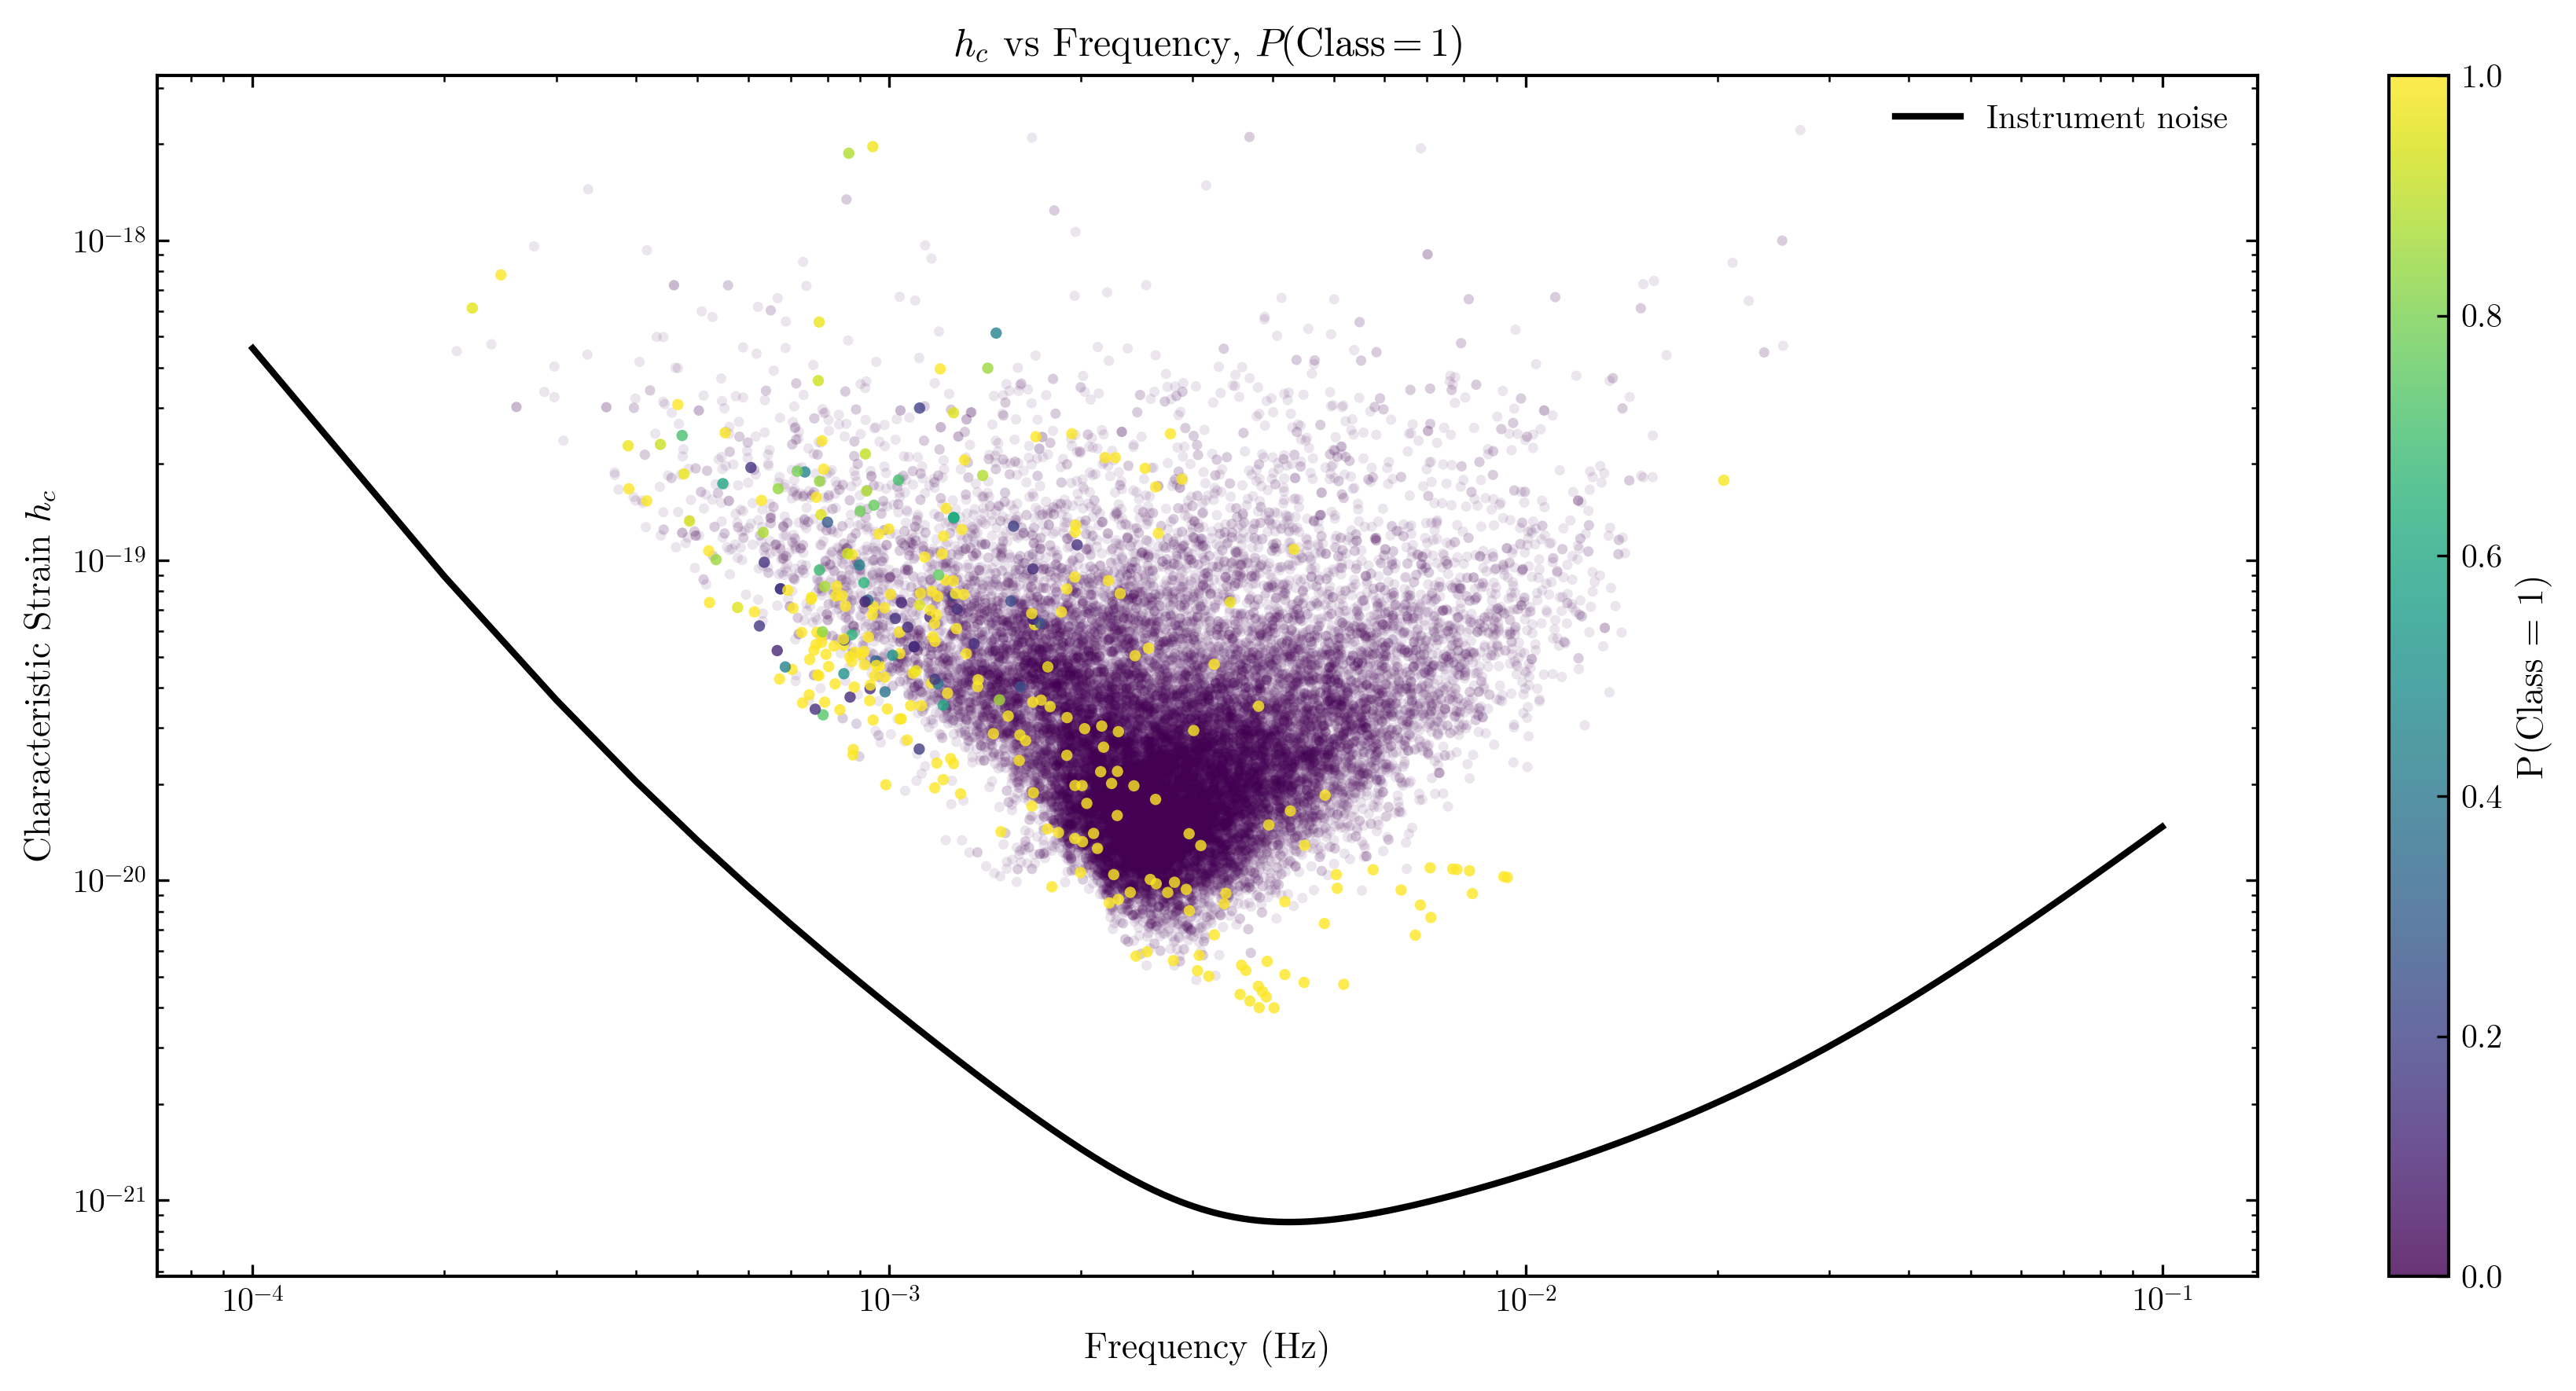

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
threshold = 0.1
low_mask  = y_pred_proba <= threshold
high_mask = ~low_mask


plt.rc('font', family='Latin Modern Roman', size=10)
norm = Normalize(vmin=0, vmax=1)
cmap = cm.viridis


plt.figure(figsize=(12, 6))
plt.loglog(f_range, np.sqrt( f_range * lisasens/2), 'k-', linewidth=2, label='Instrument noise')
#   a) low‑prob
plt.scatter(
    f[low_mask], hc[low_mask],
    c=y_pred_proba[low_mask], cmap=cmap, norm=norm,
    alpha=0.1, edgecolor='none', zorder=1, s=10
)

#   b) high‑prob
sc = plt.scatter(
    f[high_mask], hc[high_mask],
    c=y_pred_proba[high_mask], cmap=cmap, norm=norm,
    alpha=0.8, edgecolor='none', zorder=2, s=12
)


plt.xscale('log')
plt.yscale('log')   


plt.xlabel('Frequency (Hz)')
plt.ylabel('Characteristic Strain $h_c$')
plt.title(r'$h_c$ vs Frequency, $P(\mathrm{Class}=1)$')
cbar = plt.colorbar(sc)
cbar.set_label('P(Class = 1)')
plt.legend()
plt.tight_layout()

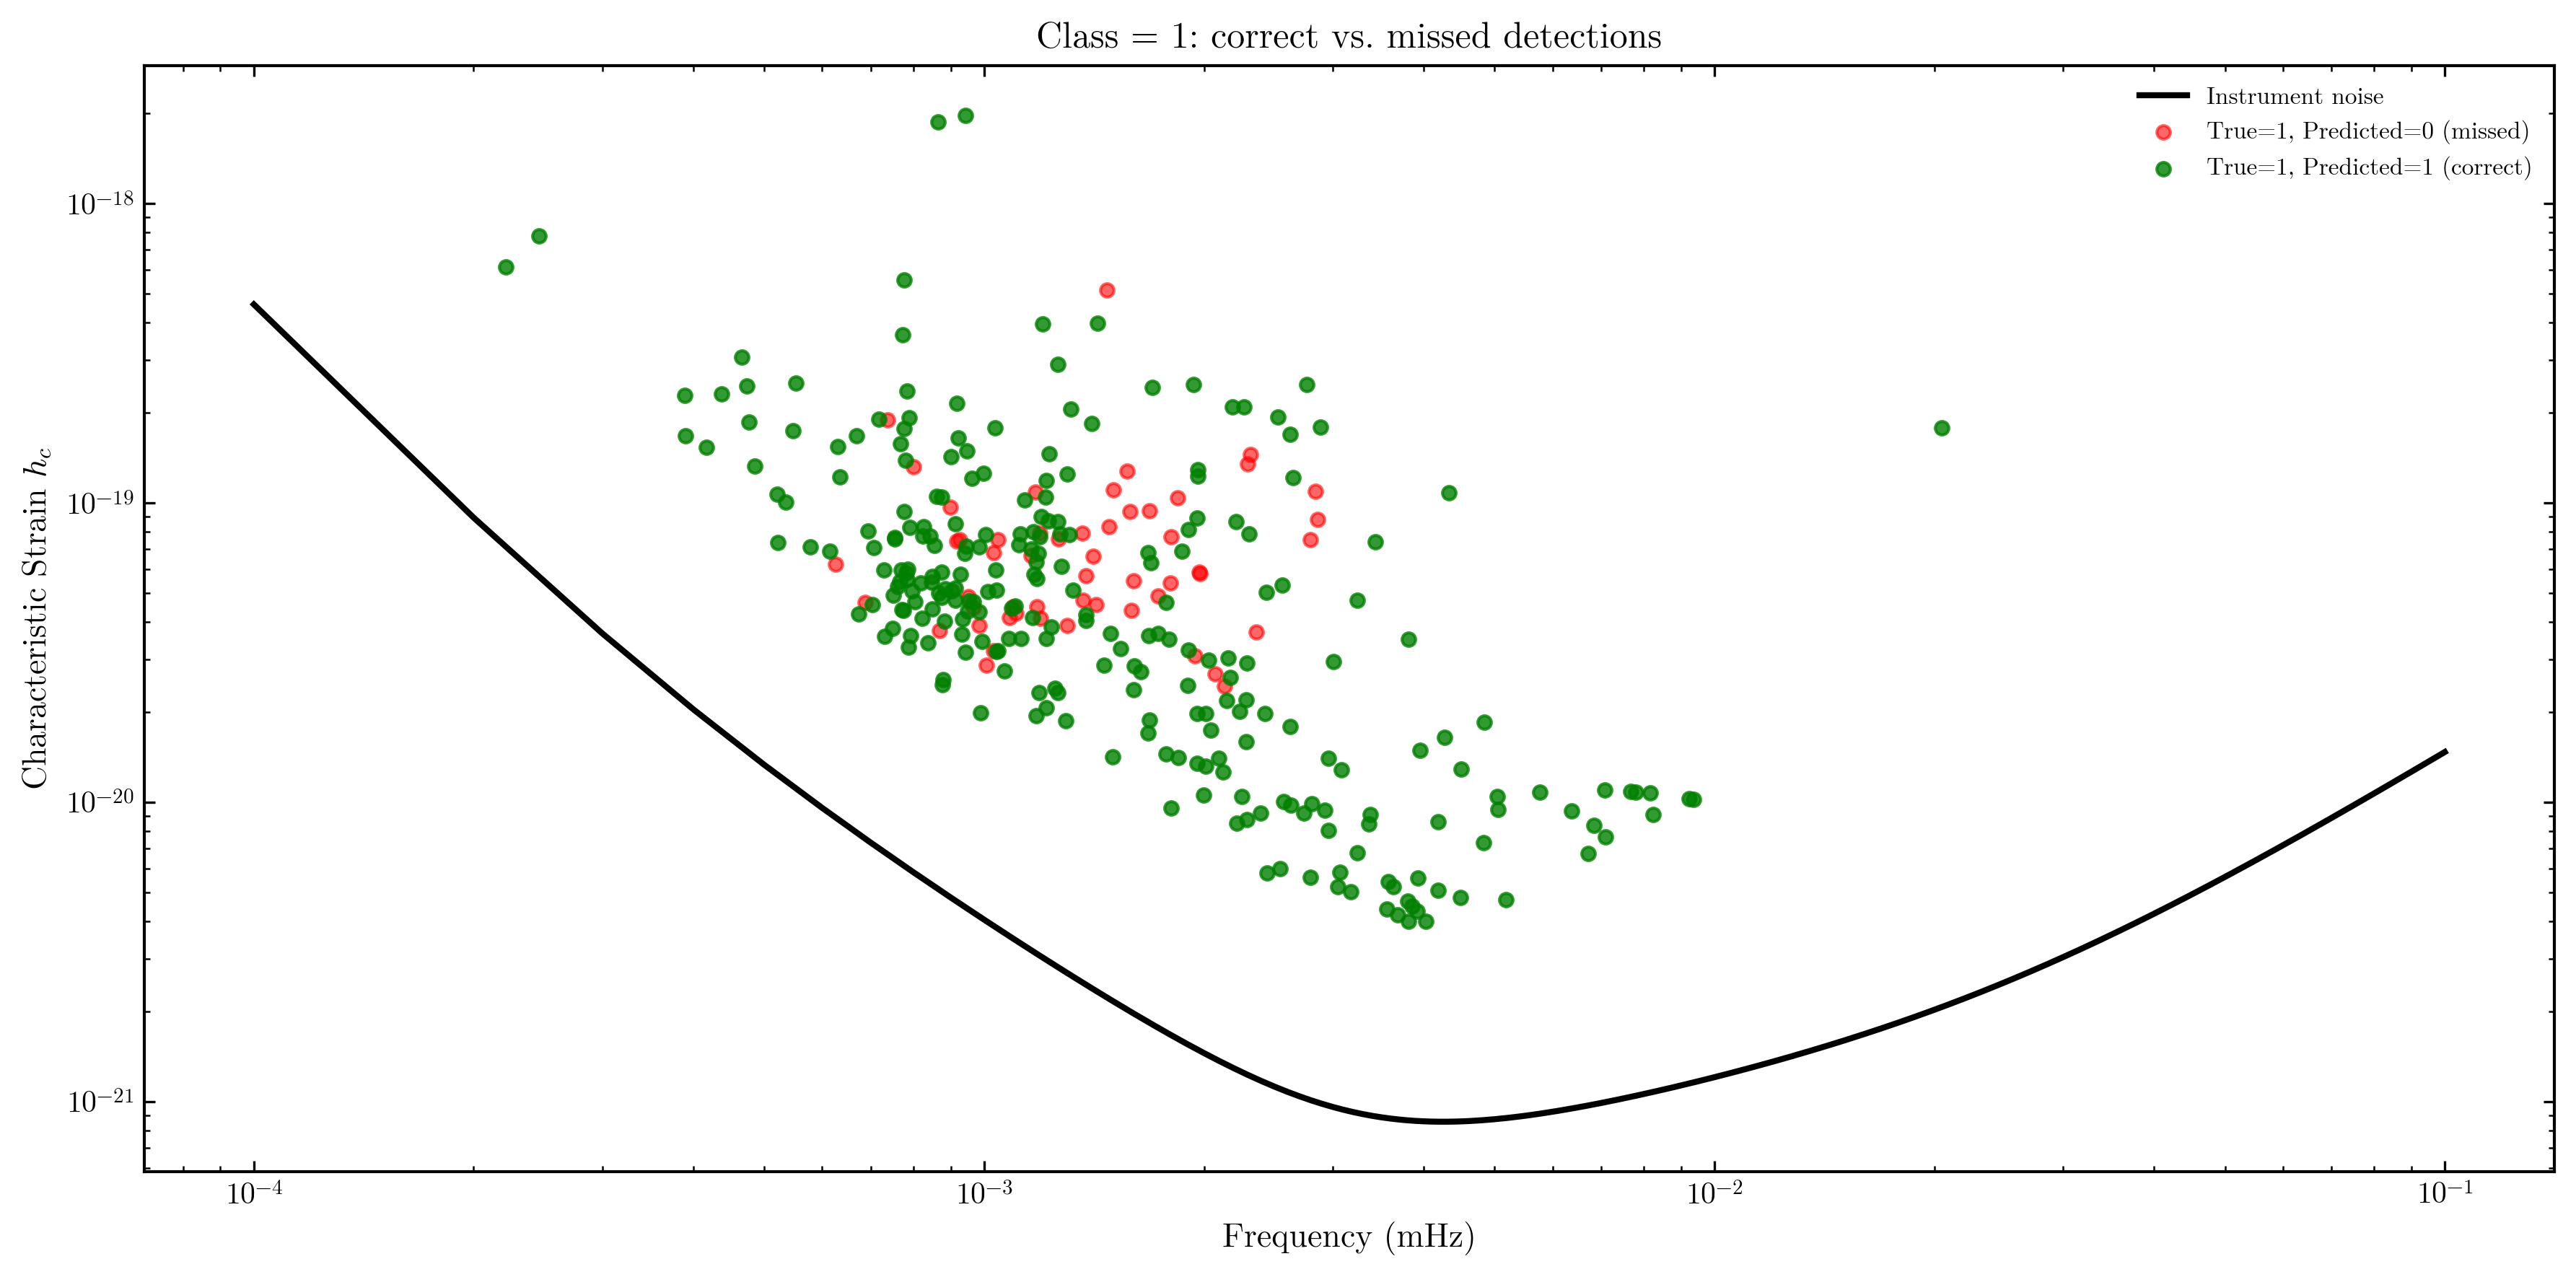

In [29]:
y_true   = y_val.values  
mask_pos = (y_true == 1)
mask_tp  = mask_pos & (y_pred == 1)   # true positives
mask_fn  = mask_pos & (y_pred == 0)   # false negatives

plt.figure(figsize=(12, 6))
plt.loglog(f_range, np.sqrt( f_range * lisasens/2), 'k-', linewidth=2, label='Instrument noise')

# a) Missed (false negatives) in red
plt.scatter(
    f[mask_fn], hc[mask_fn],
    s=20, c='red', alpha=0.6,
    label='True=1, Predicted=0 (missed)',
    zorder=1
)

# b) Correct (true positives) in green
sc = plt.scatter(
    f[mask_tp], hc[mask_tp],
    s=20, c='green', alpha=0.8,
    label='True=1, Predicted=1 (correct)',
    zorder=2
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (mHz)')
plt.ylabel(r'Characteristic Strain $h_c$')
plt.title('Class = 1: correct vs. missed detections')
plt.legend(loc='upper right', fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

# Calculating Probability

Discrete calculation

In [38]:

N = len(y_true)

# True positives, false positives, true negatives, false negatives
TP = np.sum((y_pred==1) & (y_true==1))
FP = np.sum((y_pred==1) & (y_true==0))
TN = np.sum((y_pred==0) & (y_true==0))
FN = np.sum((y_pred==0) & (y_true==1))

# Totals of each true class
N_pos = TP + FN   # # of y_true==1
N_neg = TN + FP   # # of y_true==0

In [39]:
P_A1_given_pos = TP / N_pos
P_A1_given_neg = FP / N_neg
P_A0_given_pos = FN / N_pos
P_A0_given_neg = TN / N_neg

In [40]:
P_A1 = (TP + FP) / N
P_A0 = (TN + FN) / N

In [41]:
P_pos = N_pos / N
P_neg = N_neg / N

In [42]:
P_pos_given_1 = (P_A1_given_pos * P_pos) / P_A1
P_pos_given_0 = (P_A0_given_pos * P_pos) / P_A0

In [43]:
P_posterior = {
  1: P_pos_given_1,   # probability y=1 given model predicted 1
  0: P_pos_given_0    # probability y=1 given model predicted 0
}

In [44]:
P_posterior

{1: 0.9886363636363636, 0: 0.001982642525811761}

- When model predicts 1, the probability the true label is 1 is 98.86%.
- When model predicts 0, the probability the true label is 1 is only 0.20%.

# Continuous Output

# Bayesian Optimization

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import shap

/Users/irwin/opt/anaconda3/envs/sbi_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
selected_features = [
    'Frequency_mHz', 
    'Amplitude_log10', 
    'FrequencyDerivative_log10', 
    'SNR', 
    'Eccentricity',
    'EclipticLatitude_sin',
    'Inclination_cos',
    'Polarization',
    'EclipticLongitude',
    'InitialPhase'
]
X = resolved_df[selected_features]
y = resolved_df['Class']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

#Define search space
param_space = {
    # number of trees
    'n_estimators': Integer(50, 500),
    # tree depth
    'max_depth':    Integer(3, 12),
    # learning rate (log-uniform distribution)
    'learning_rate': Real(1e-3, 0.3,  prior='log-uniform'),
    # fraction of samples per tree
    'subsample':    Real(0.5, 1.0,  prior='uniform'),
    # fraction of features per tree
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),
    # regularisation
    'gamma':        Real(0, 5,       prior='uniform'),
    'min_child_weight': Integer(1, 10),
}

#Set up the BayesSearchCV
bayes_cv = BayesSearchCV(
    estimator = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        random_state=1
    ),
    search_spaces      = param_space,
    n_iter             = 32,            # number of parameter settings to try
    scoring            = 'roc_auc',     # optimise AUC
    cv                 = 3,             # 3-fold CV on the training set
    n_jobs             = -1,            # parallelise across all CPUs
    random_state       = 1,
    verbose            = 0
)

#Run the search
bayes_cv.fit(X_train_scaled, y_train)

/Users/irwin/opt/anaconda3/envs/sbi_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:34:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/irwin/opt/anaconda3/envs/sbi_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:34:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/irwin/opt/anaconda3/envs/sbi_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:34:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/irwin/opt/anaconda3/envs/sbi_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:34:29] WARNING: /Users/runner/work/xgboost/xgboost/src/

In [ ]:
print("Best CV AUC: {:.4f}".format(bayes_cv.best_score_))
print("Best hyperparameters:")
for param, val in bayes_cv.best_params_.items():
    print(f"  • {param}: {val}")

y_val_pred = bayes_cv.predict_proba(X_val_scaled)[:, 1]
val_auc    = roc_auc_score(y_val, y_val_pred)
print(f"Validation AUC: {val_auc:.4f}")

best_params = bayes_cv.best_params_
final_model = XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=1
)
final_model.fit(
    scaler.fit_transform(X_train_val),  # re-fit scaler on train+val
    y_train_val
)
y_test_pred = final_model.predict_proba(X_test_scaled)[:, 1]
test_auc    = roc_auc_score(y_test, y_test_pred)
print(f"Test AUC: {test_auc:.4f}")

NameError: name 'bayes_cv' is not defined

In [ ]:
y_val_pred_proba = final_model.predict_proba(X_val_scaled)[:, 1]
y_val_pred = final_model.predict(X_val_scaled)
test_auc    = roc_auc_score(y_val, y_val_pred_proba)
print(f"Test AUC: {test_auc:.4f}")

Test AUC: 0.9995


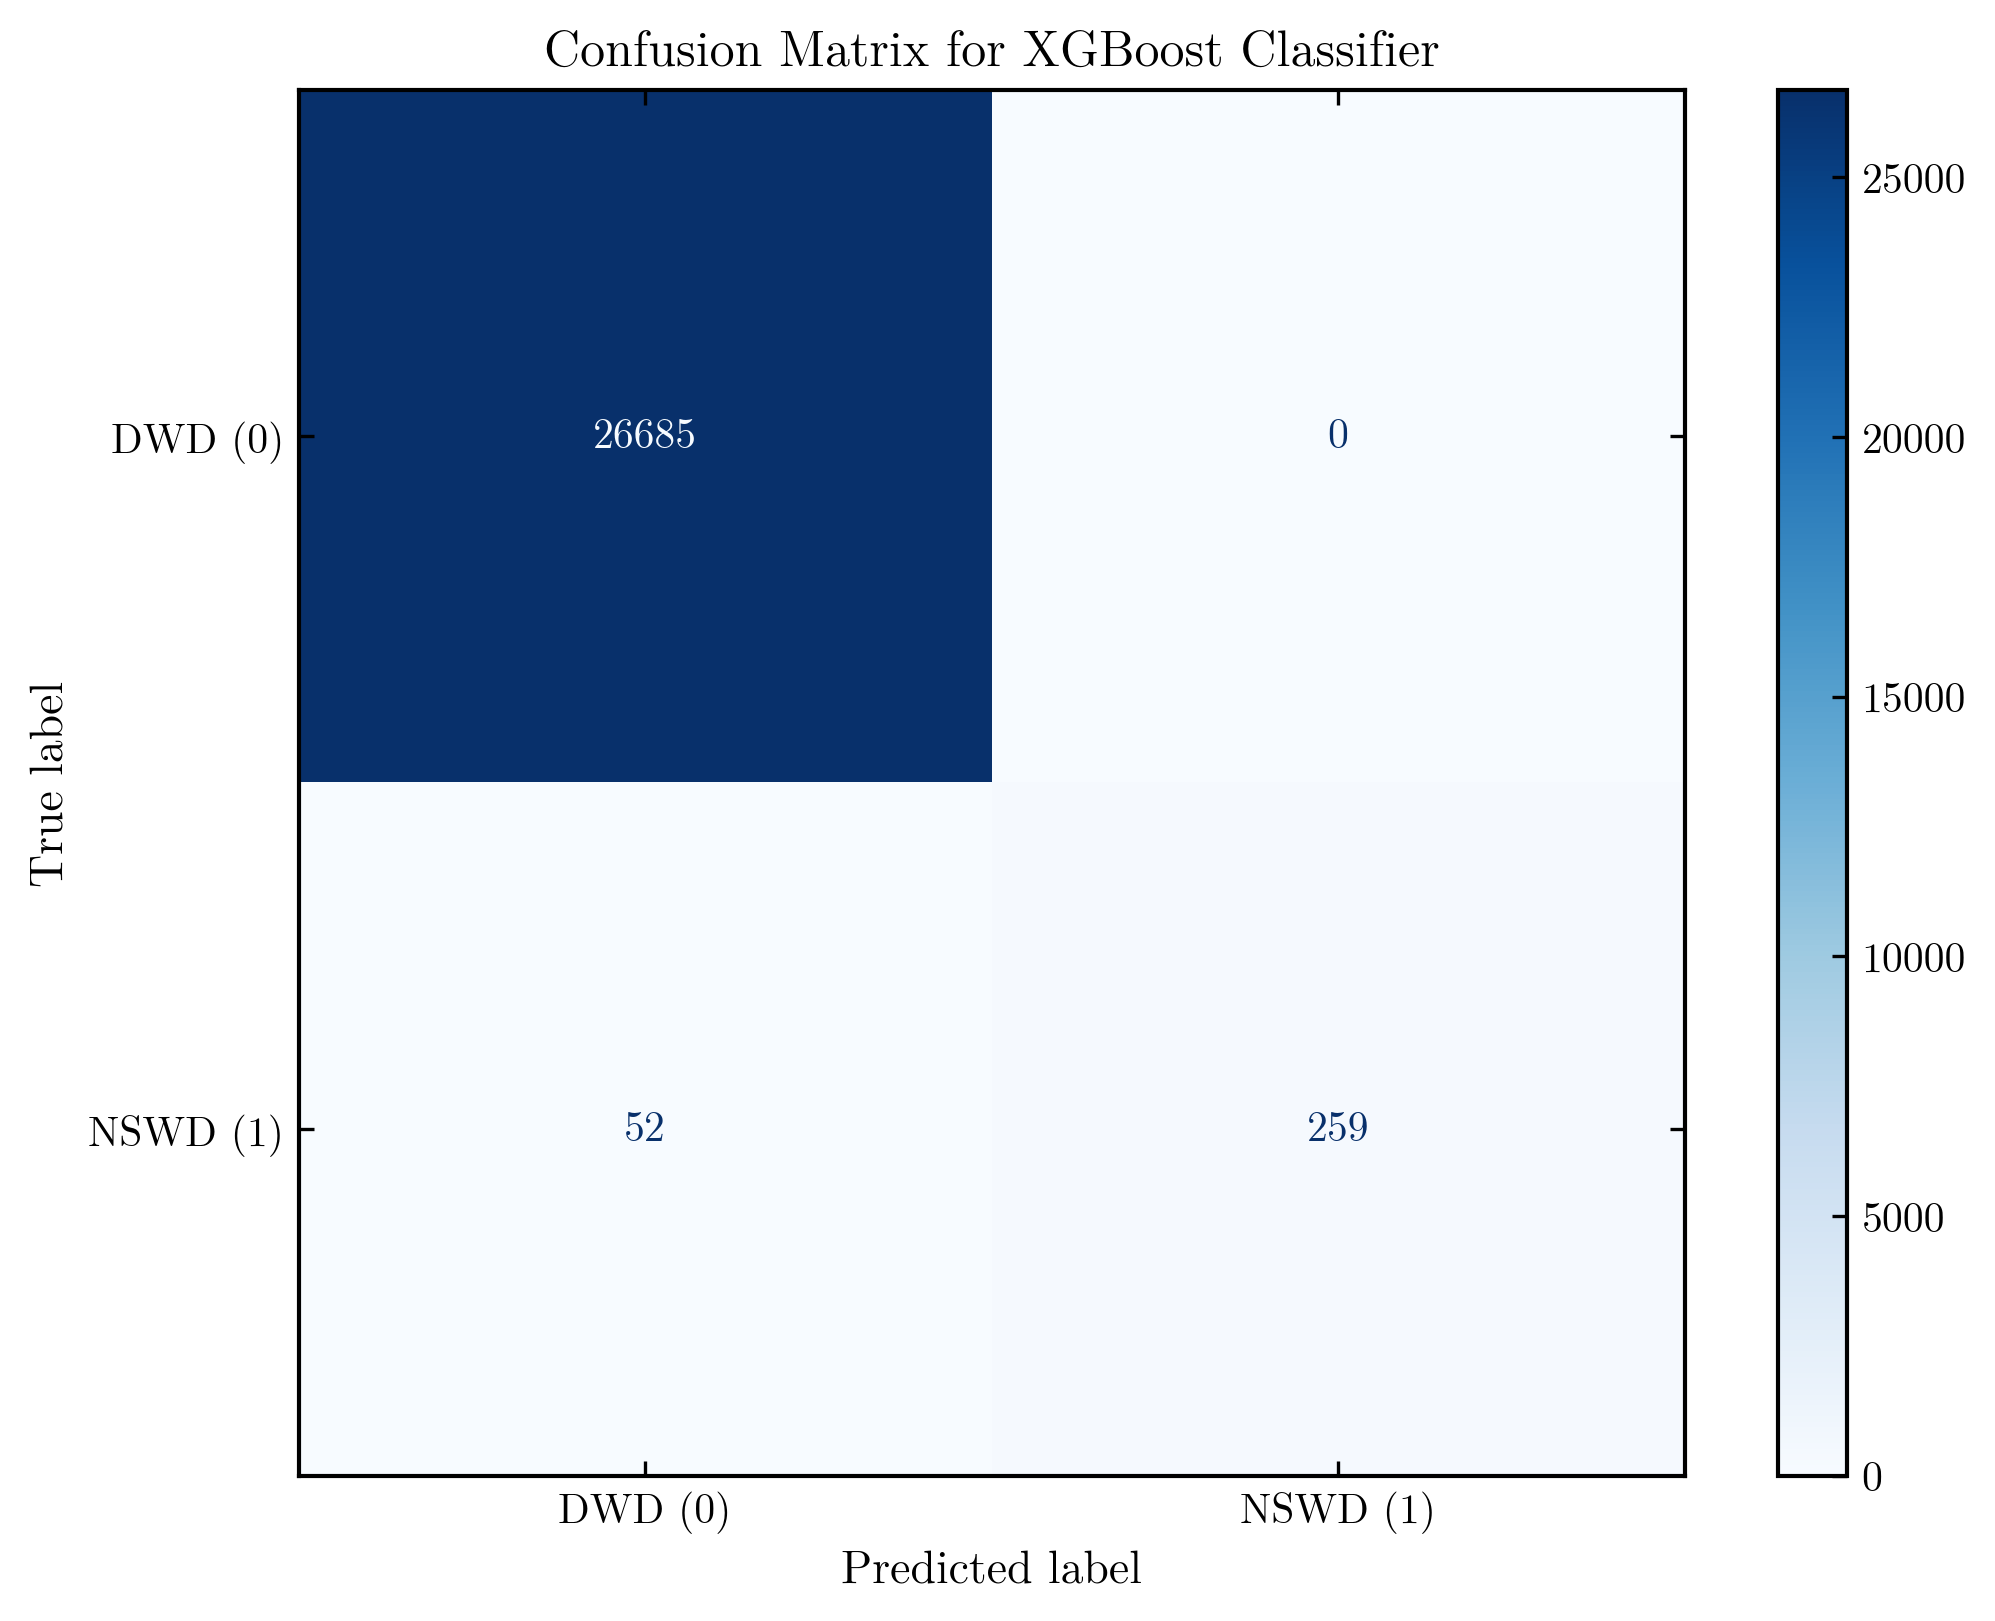

In [ ]:
cm = confusion_matrix(y_val, y_val_pred, labels=[0, 1])  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DWD (0)', 'NSWD (1)'])

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for XGBoost Classifier")
plt.grid(False)
plt.show()

## SHAP explain

In [44]:
explainer = shap.TreeExplainer(final_model)

In [46]:
X_val_df = pd.DataFrame(
    X_val_scaled, 
    columns=selected_features,
    index=X_val.index  
)

shap_values = explainer.shap_values(X_val_df)


In [49]:
shap_values.shape

(26996, 10)

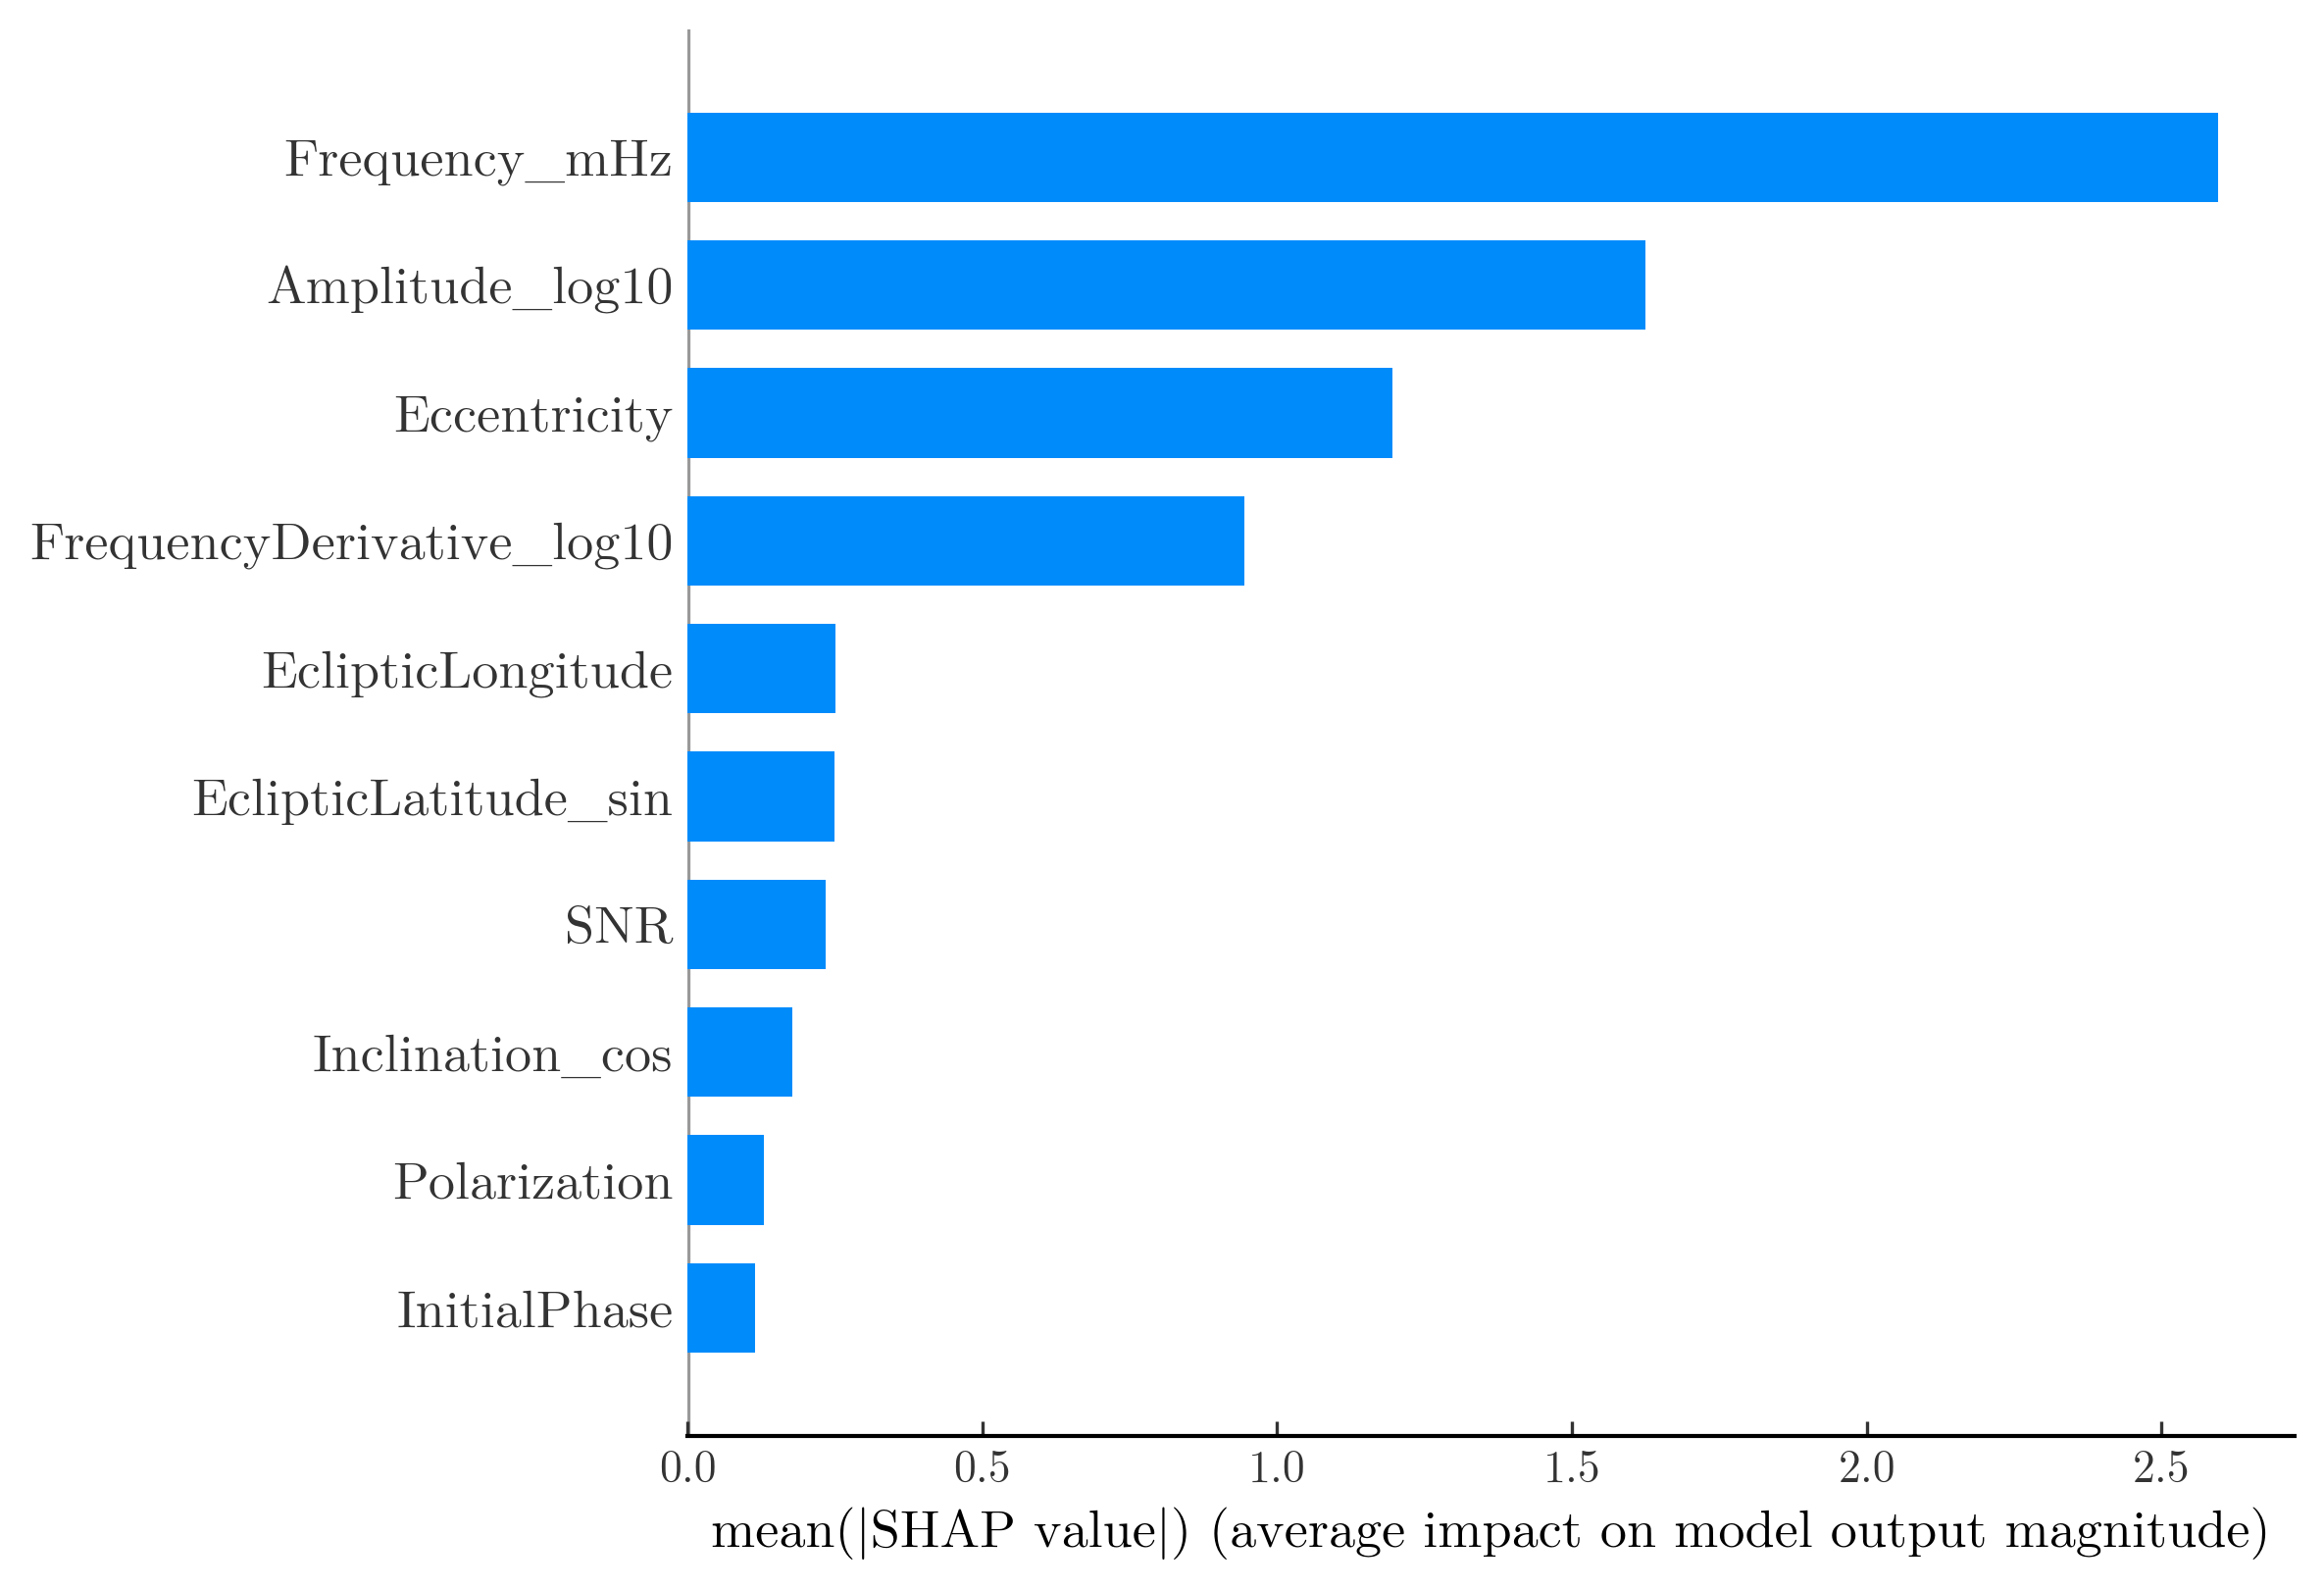

In [50]:
shap.summary_plot(
    shap_values, 
    X_val_df, 
    plot_type='bar',
    feature_names=selected_features
)

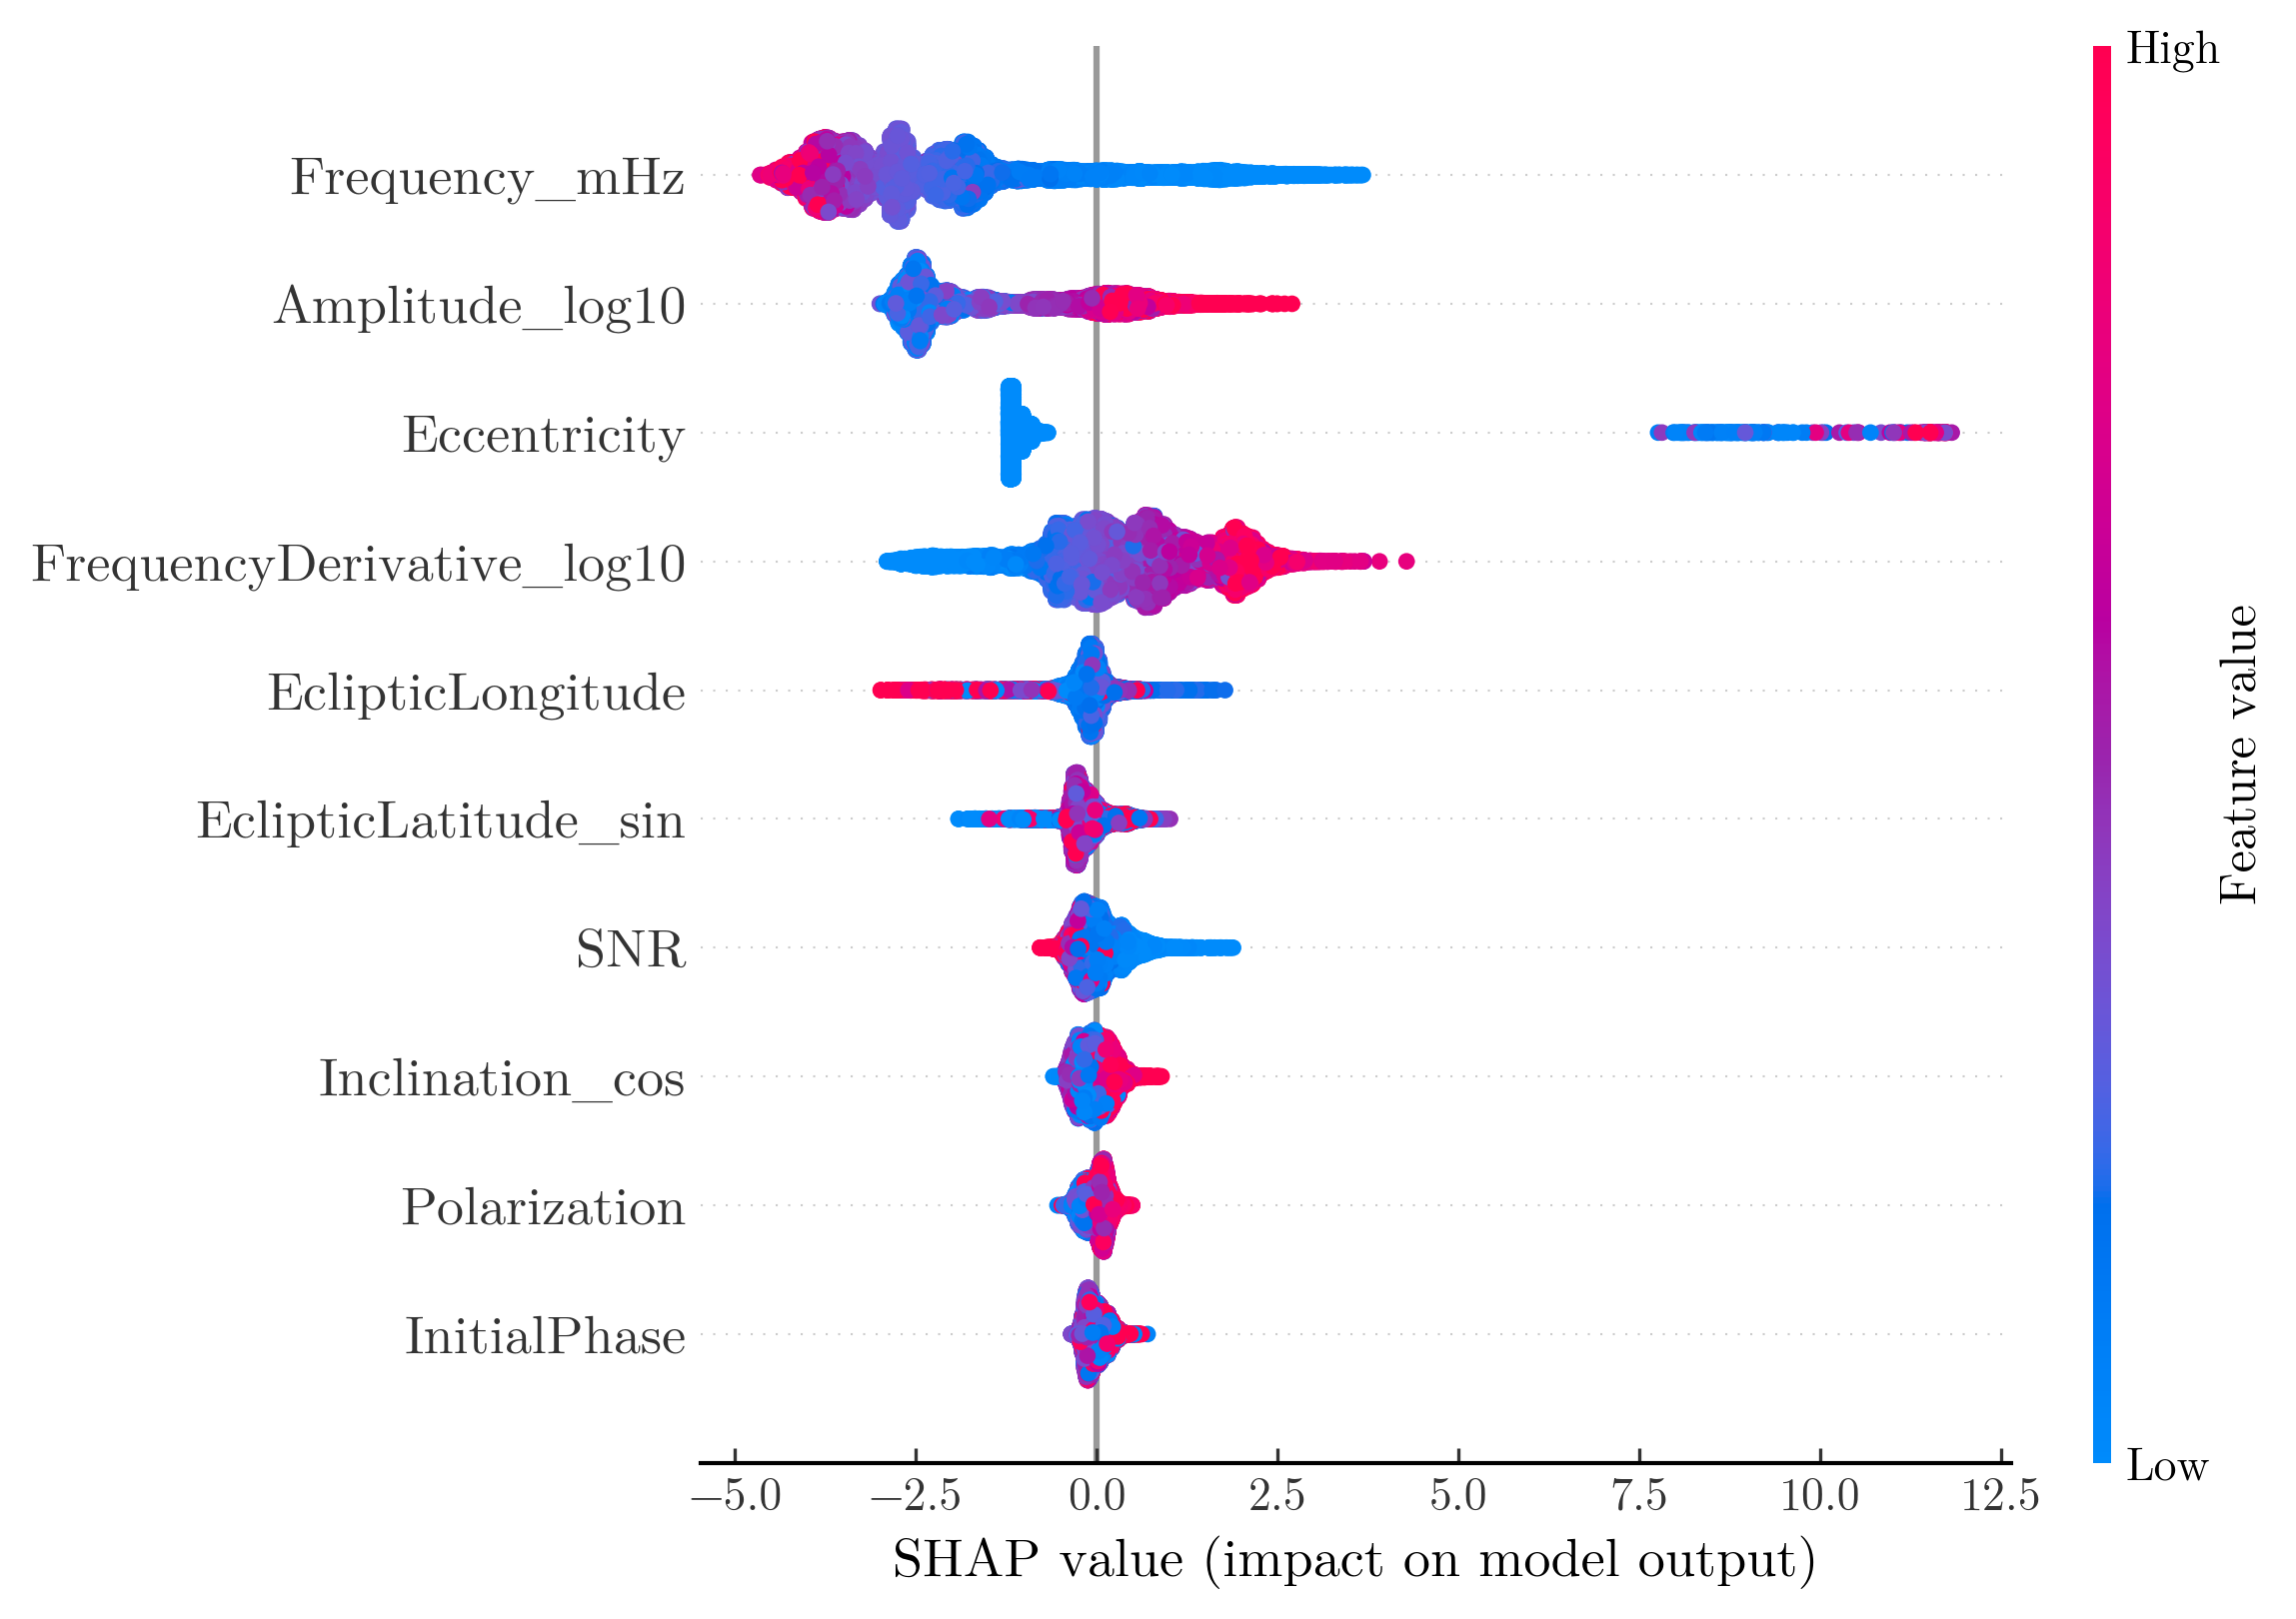

In [51]:
shap.summary_plot(
    shap_values, 
    X_val_df, 
    feature_names=selected_features
)


In [58]:
selected_features

['Frequency_mHz',
 'Amplitude_log10',
 'FrequencyDerivative_log10',
 'SNR',
 'Eccentricity',
 'EclipticLatitude_sin',
 'Inclination_cos',
 'Polarization',
 'EclipticLongitude',
 'InitialPhase']

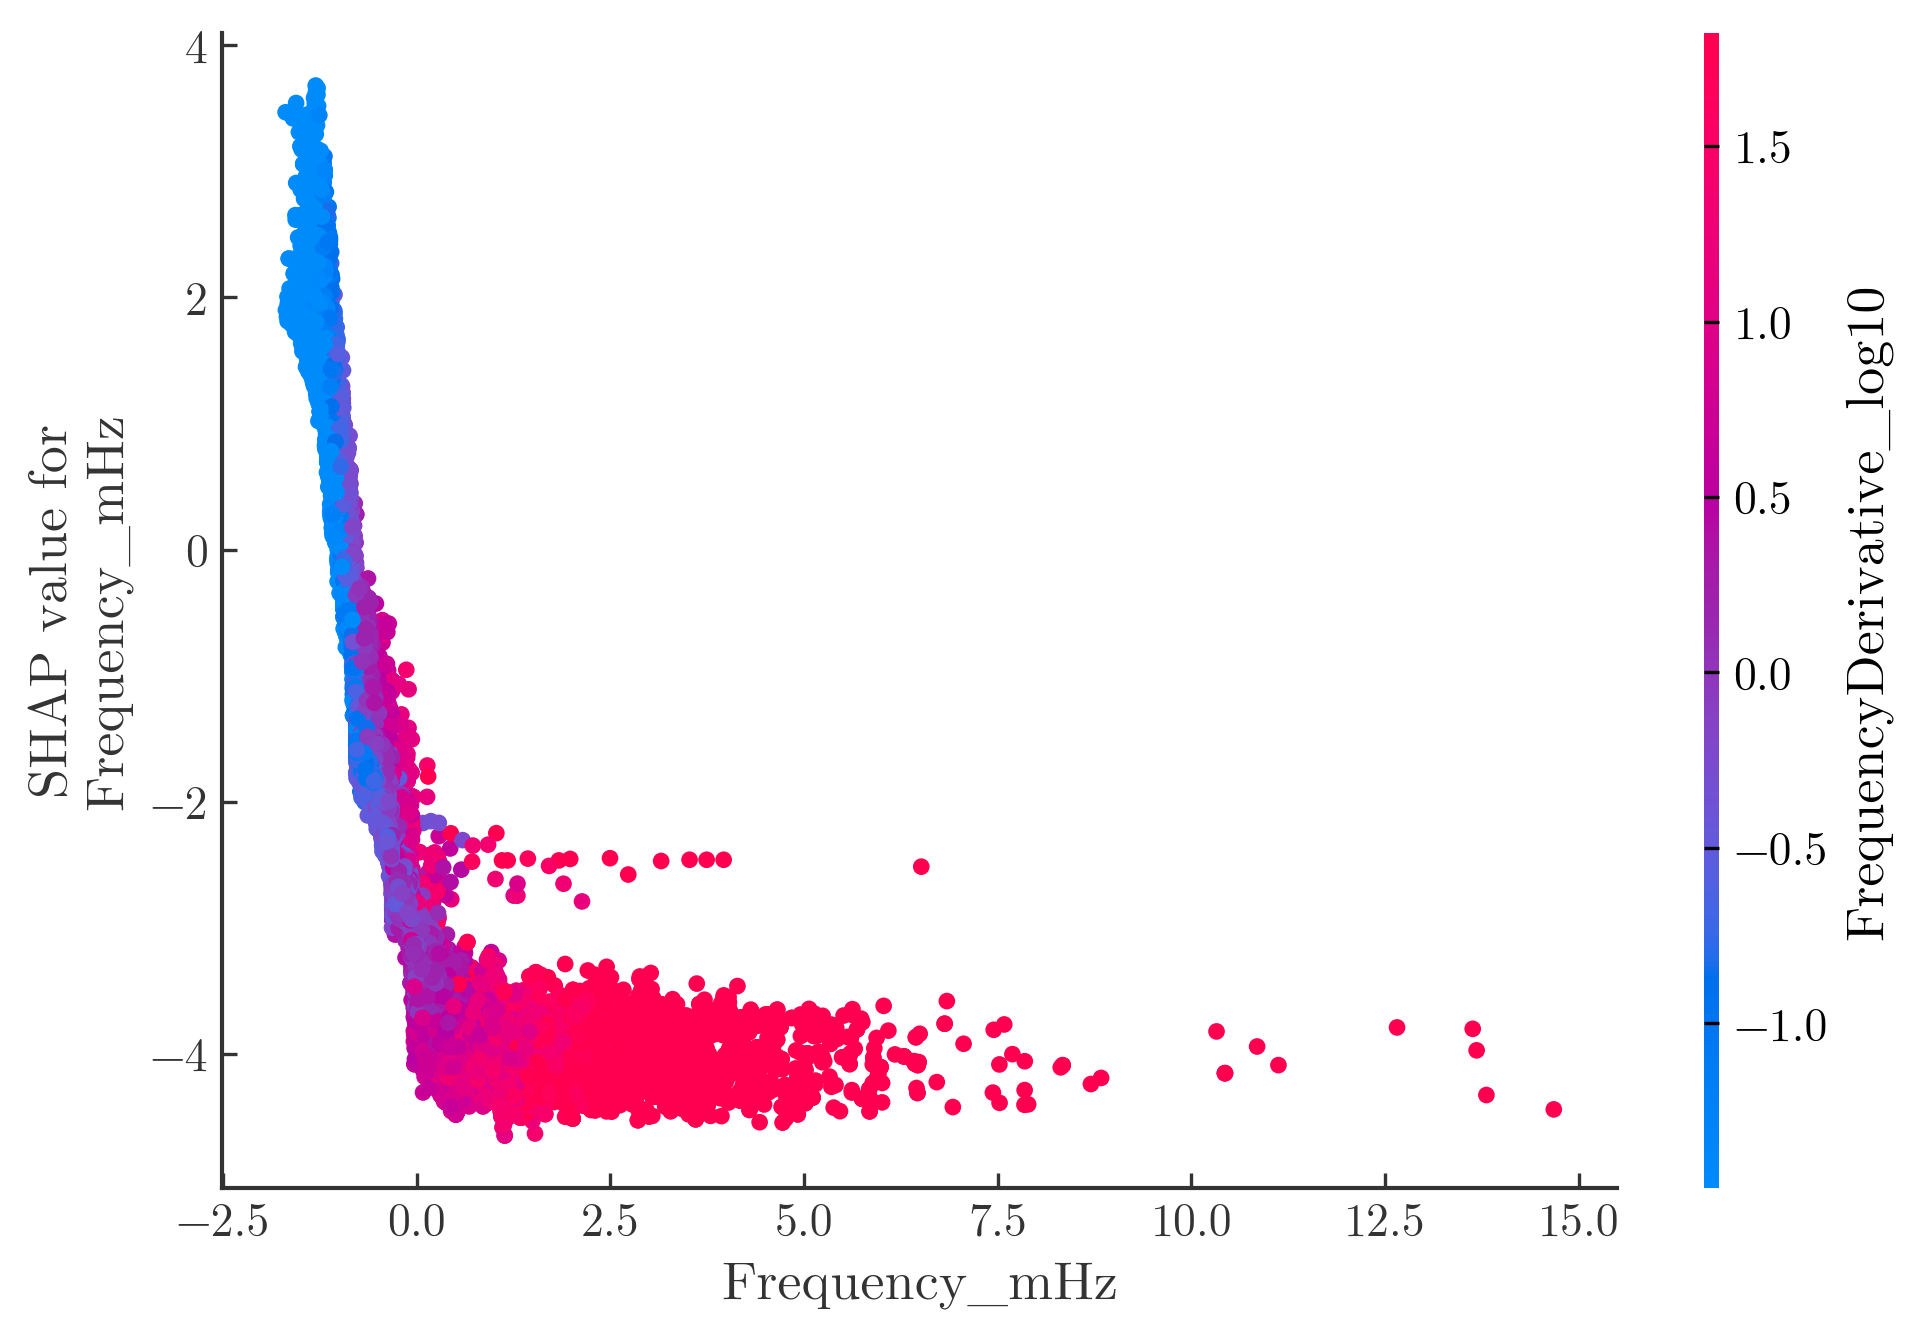

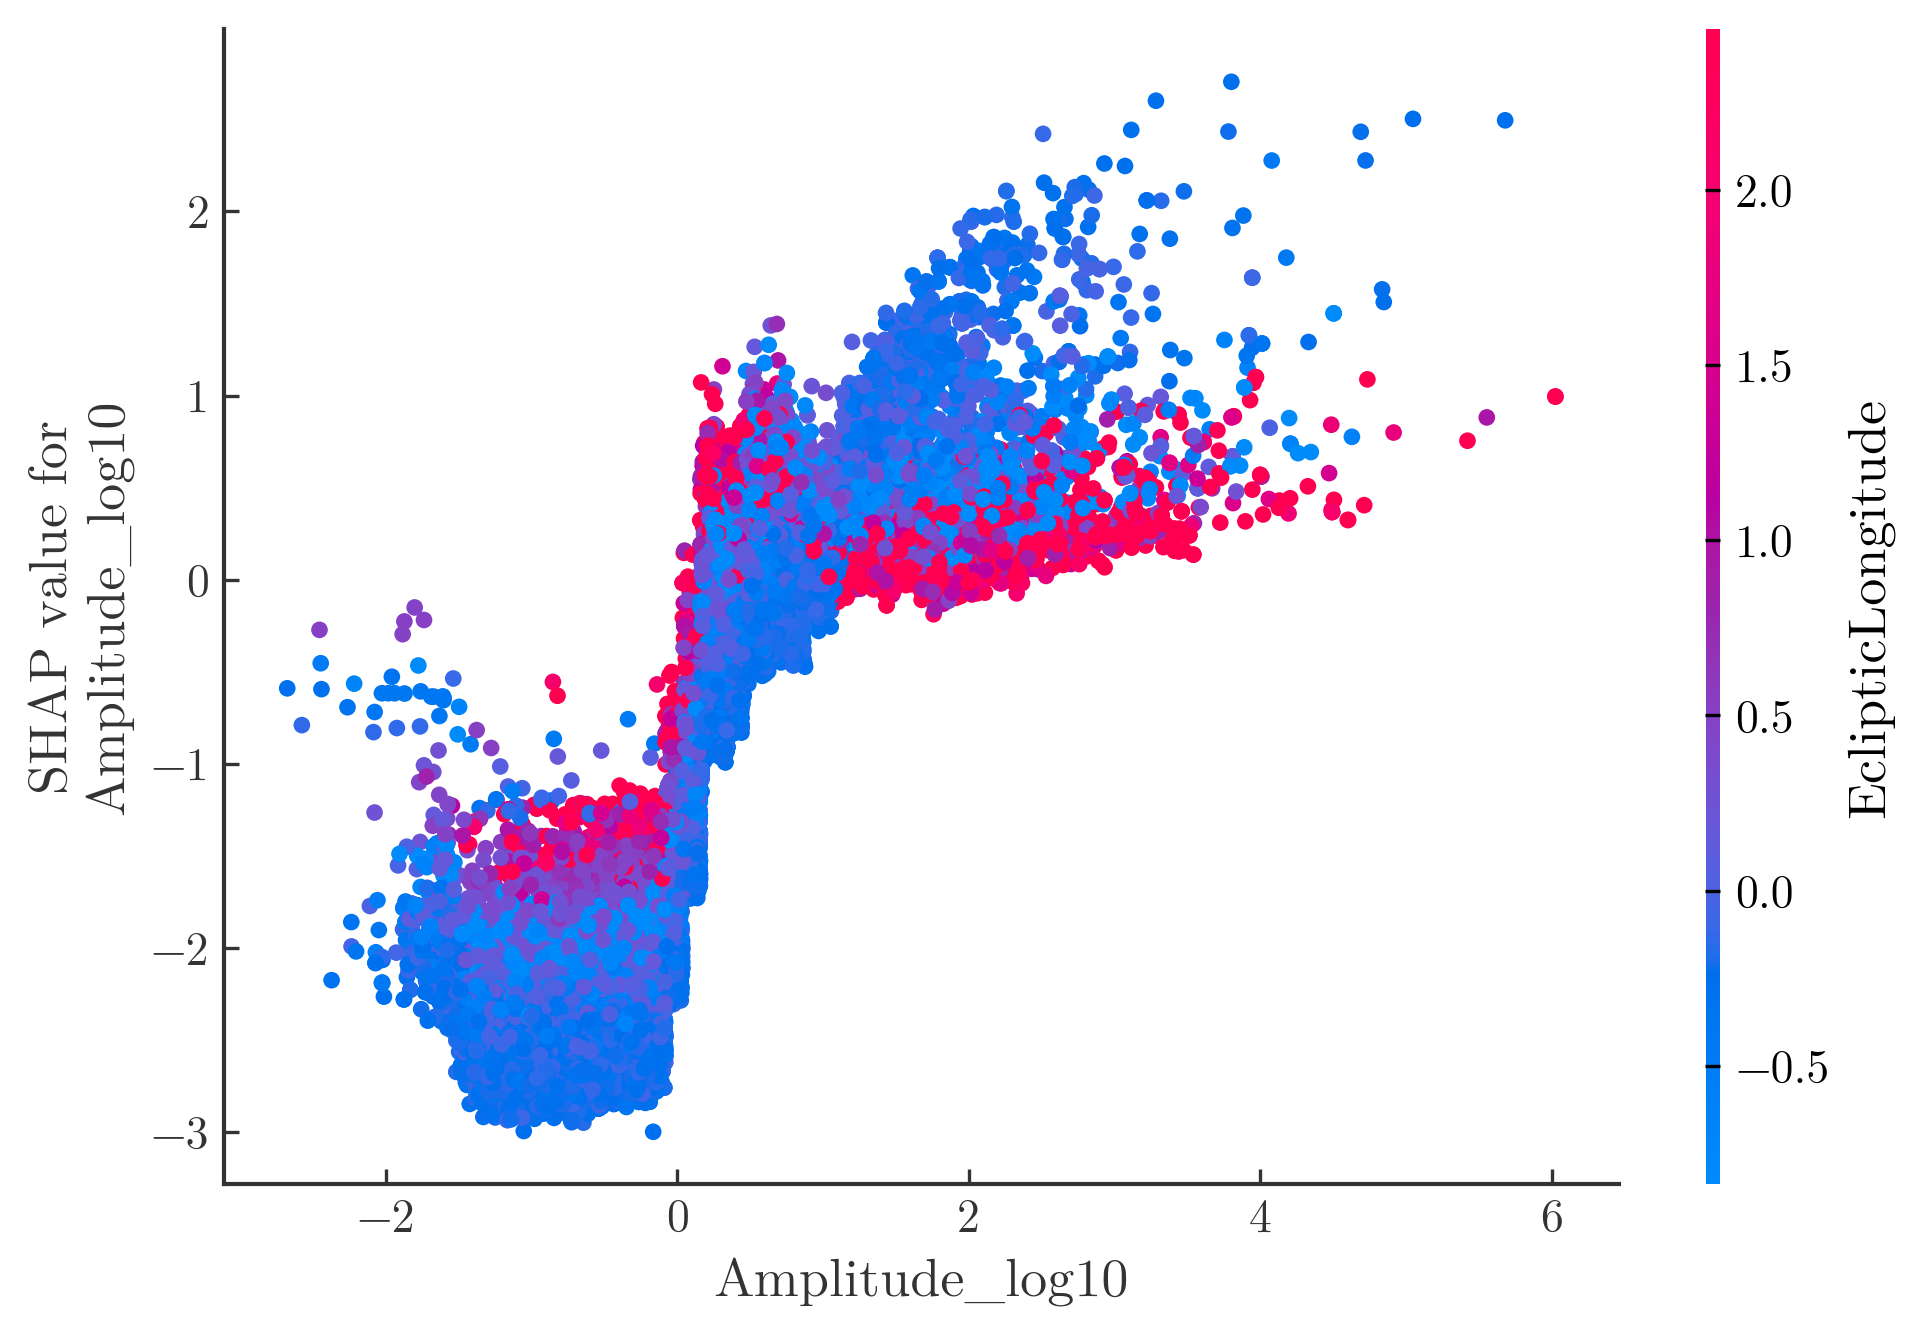

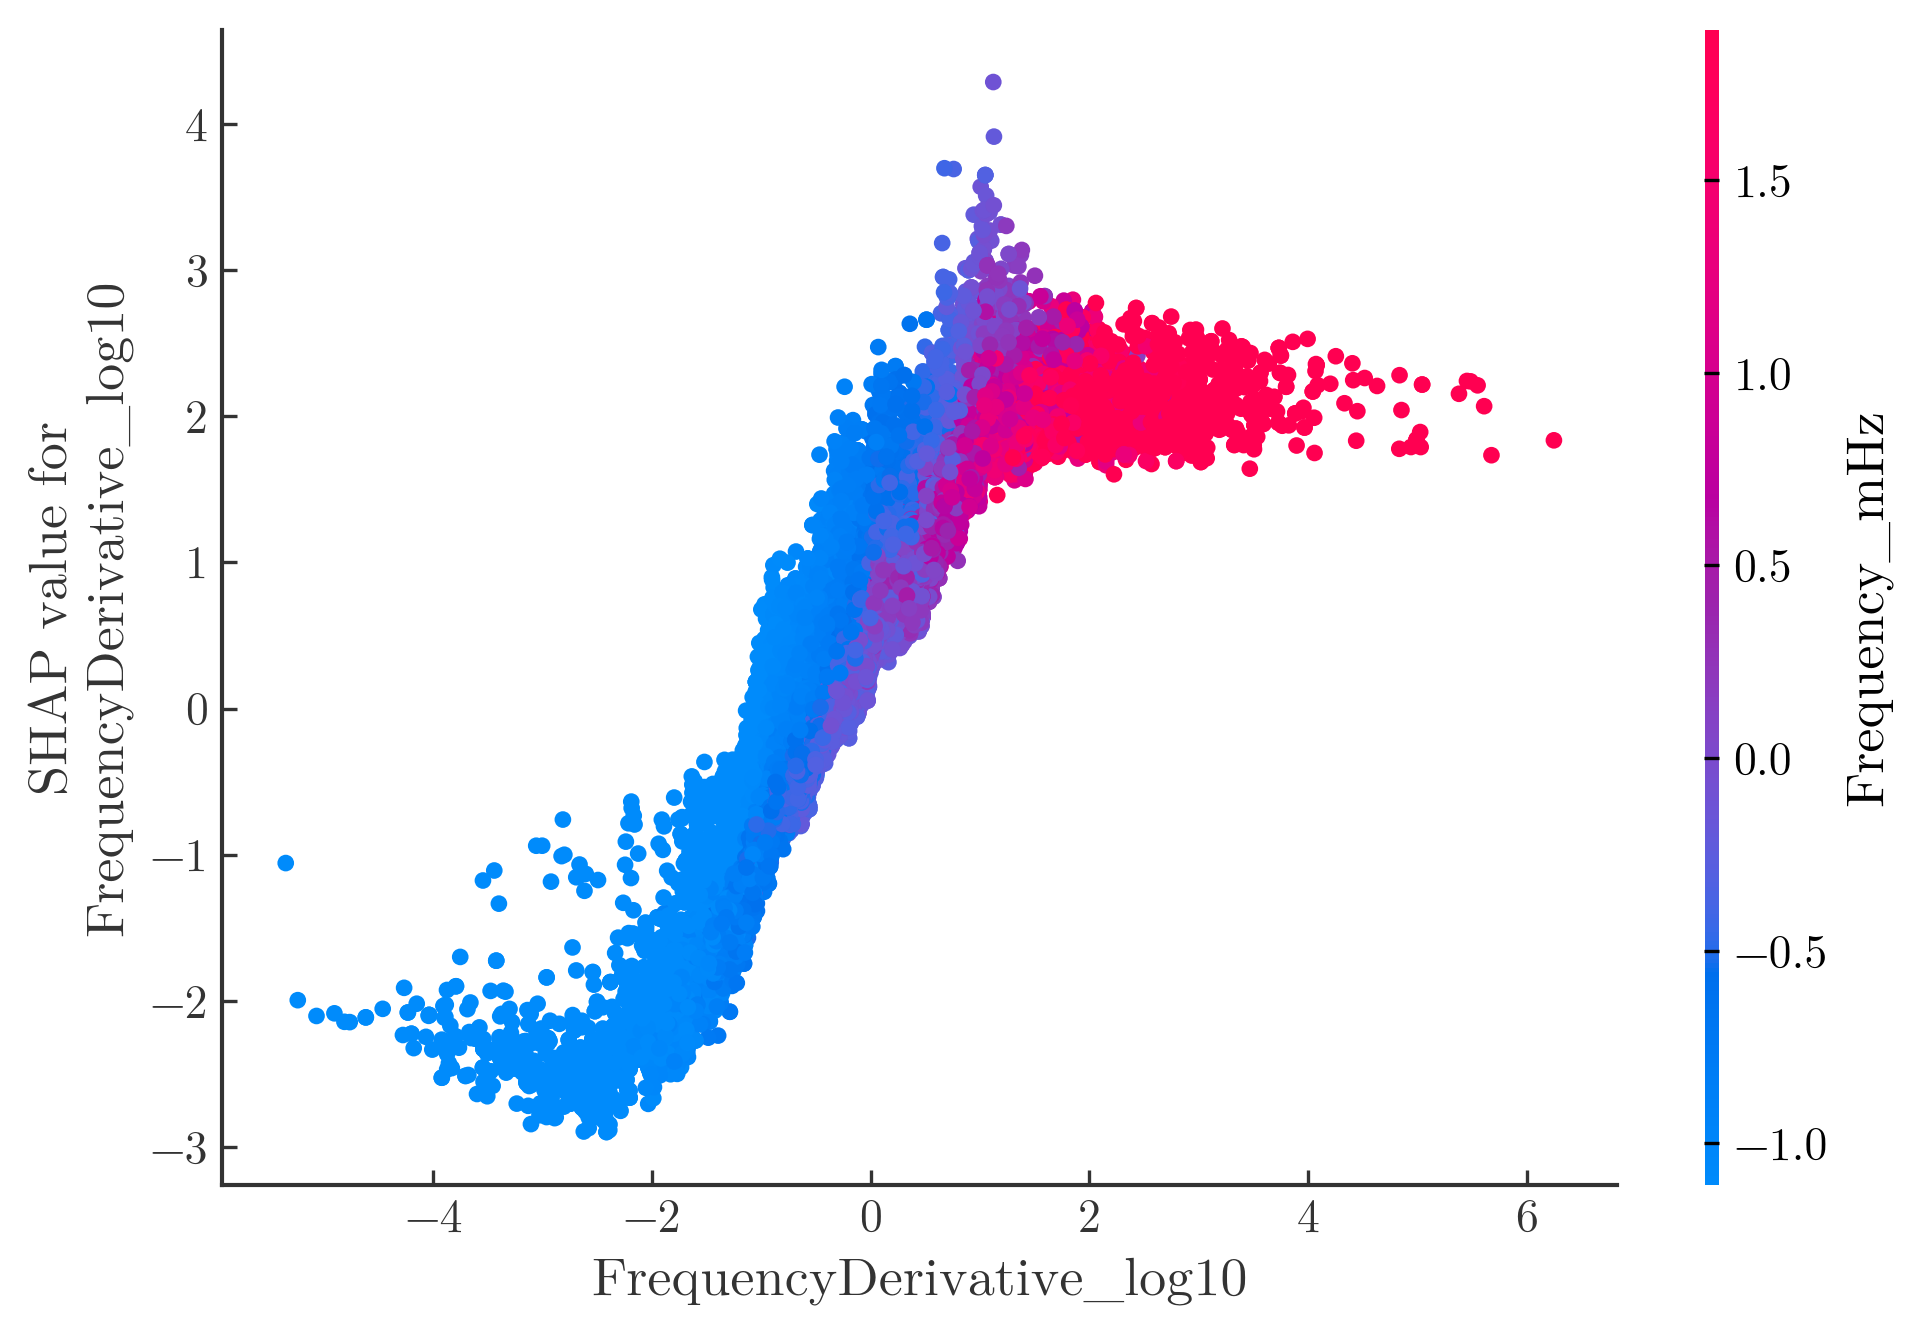

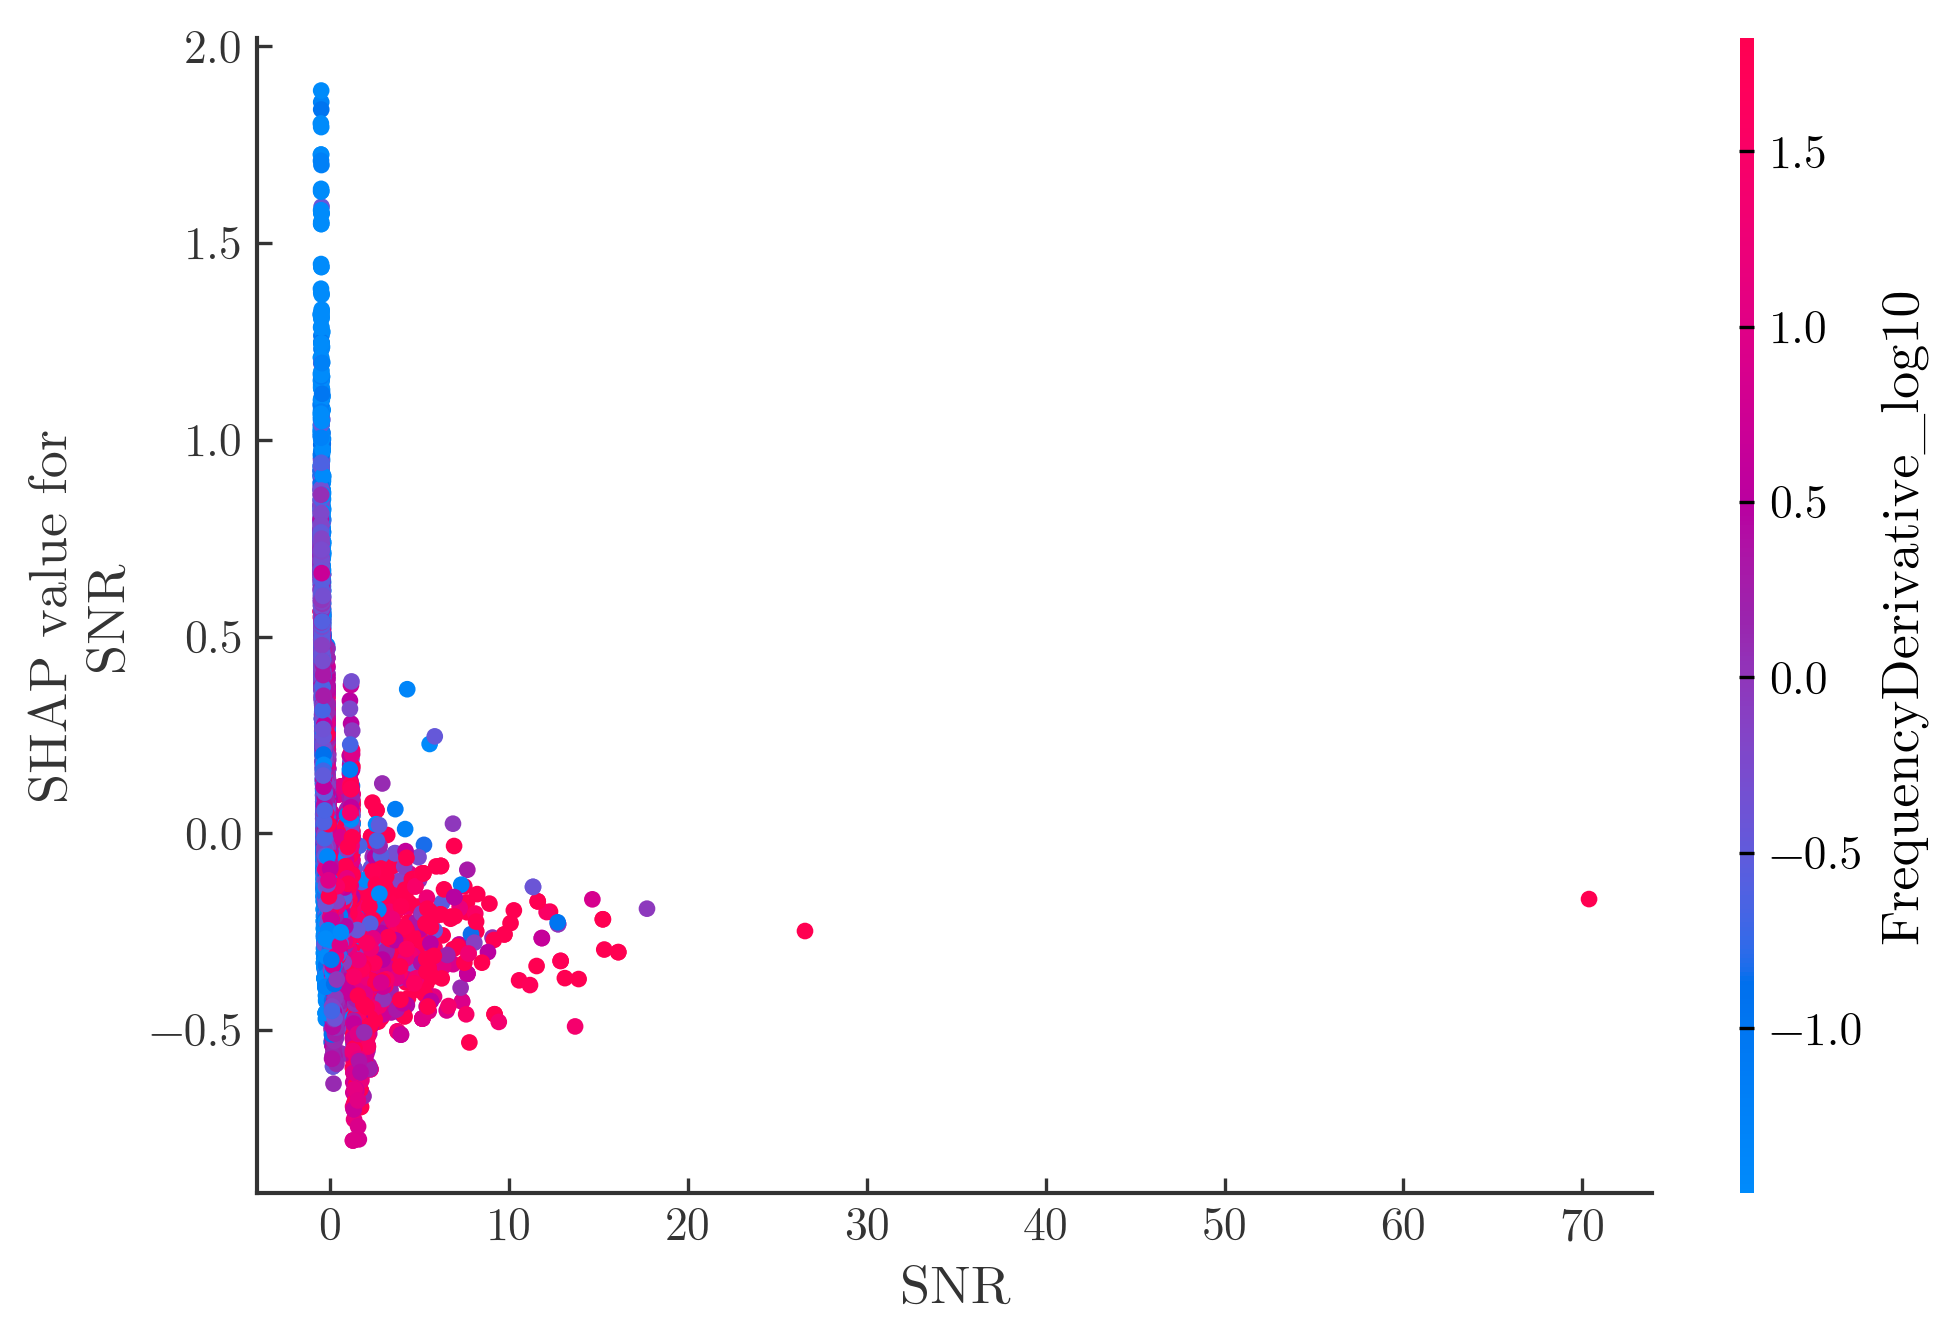

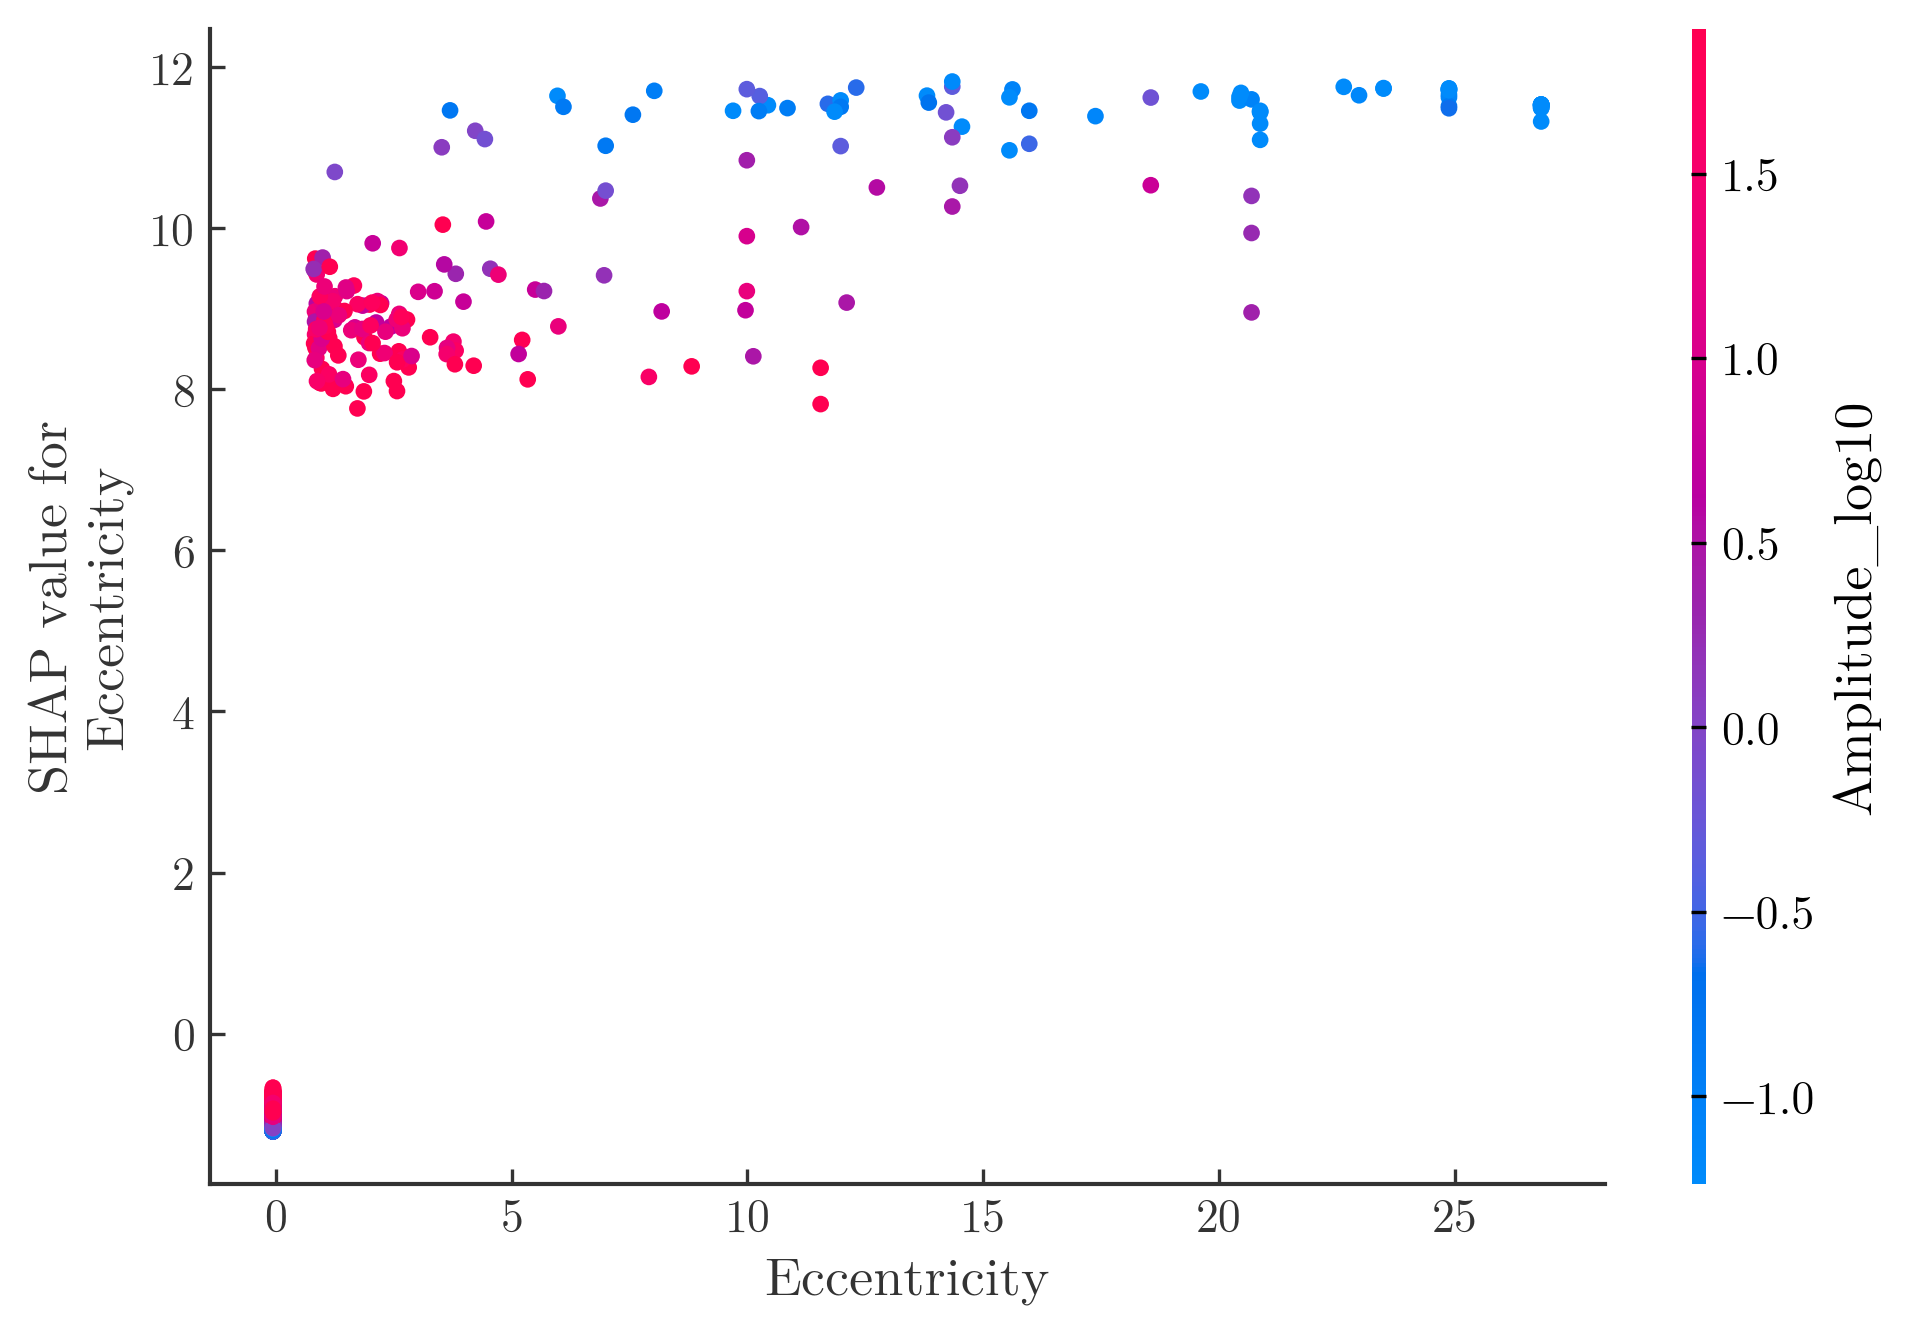

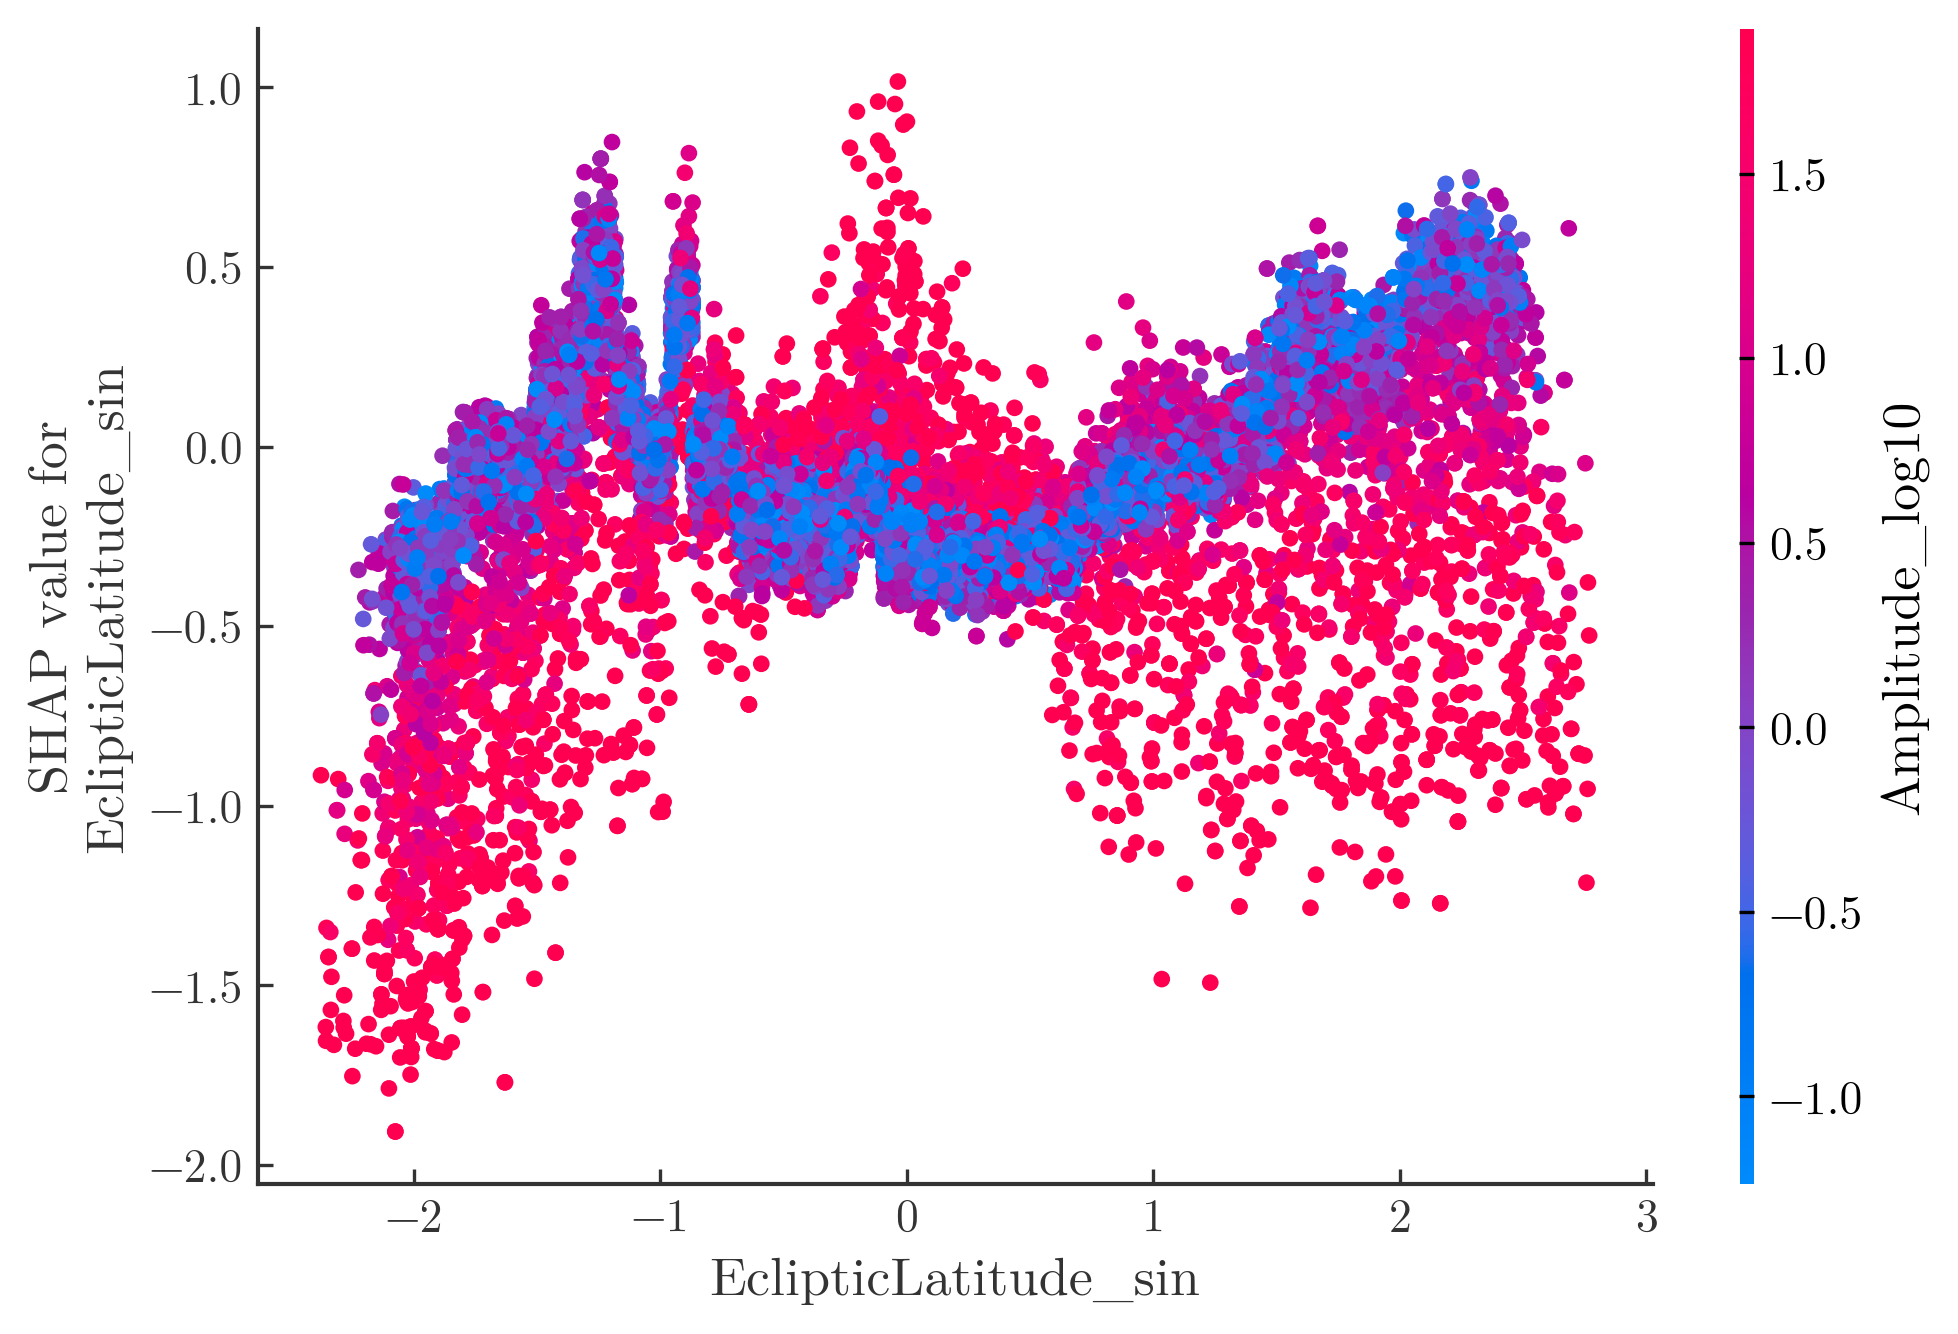

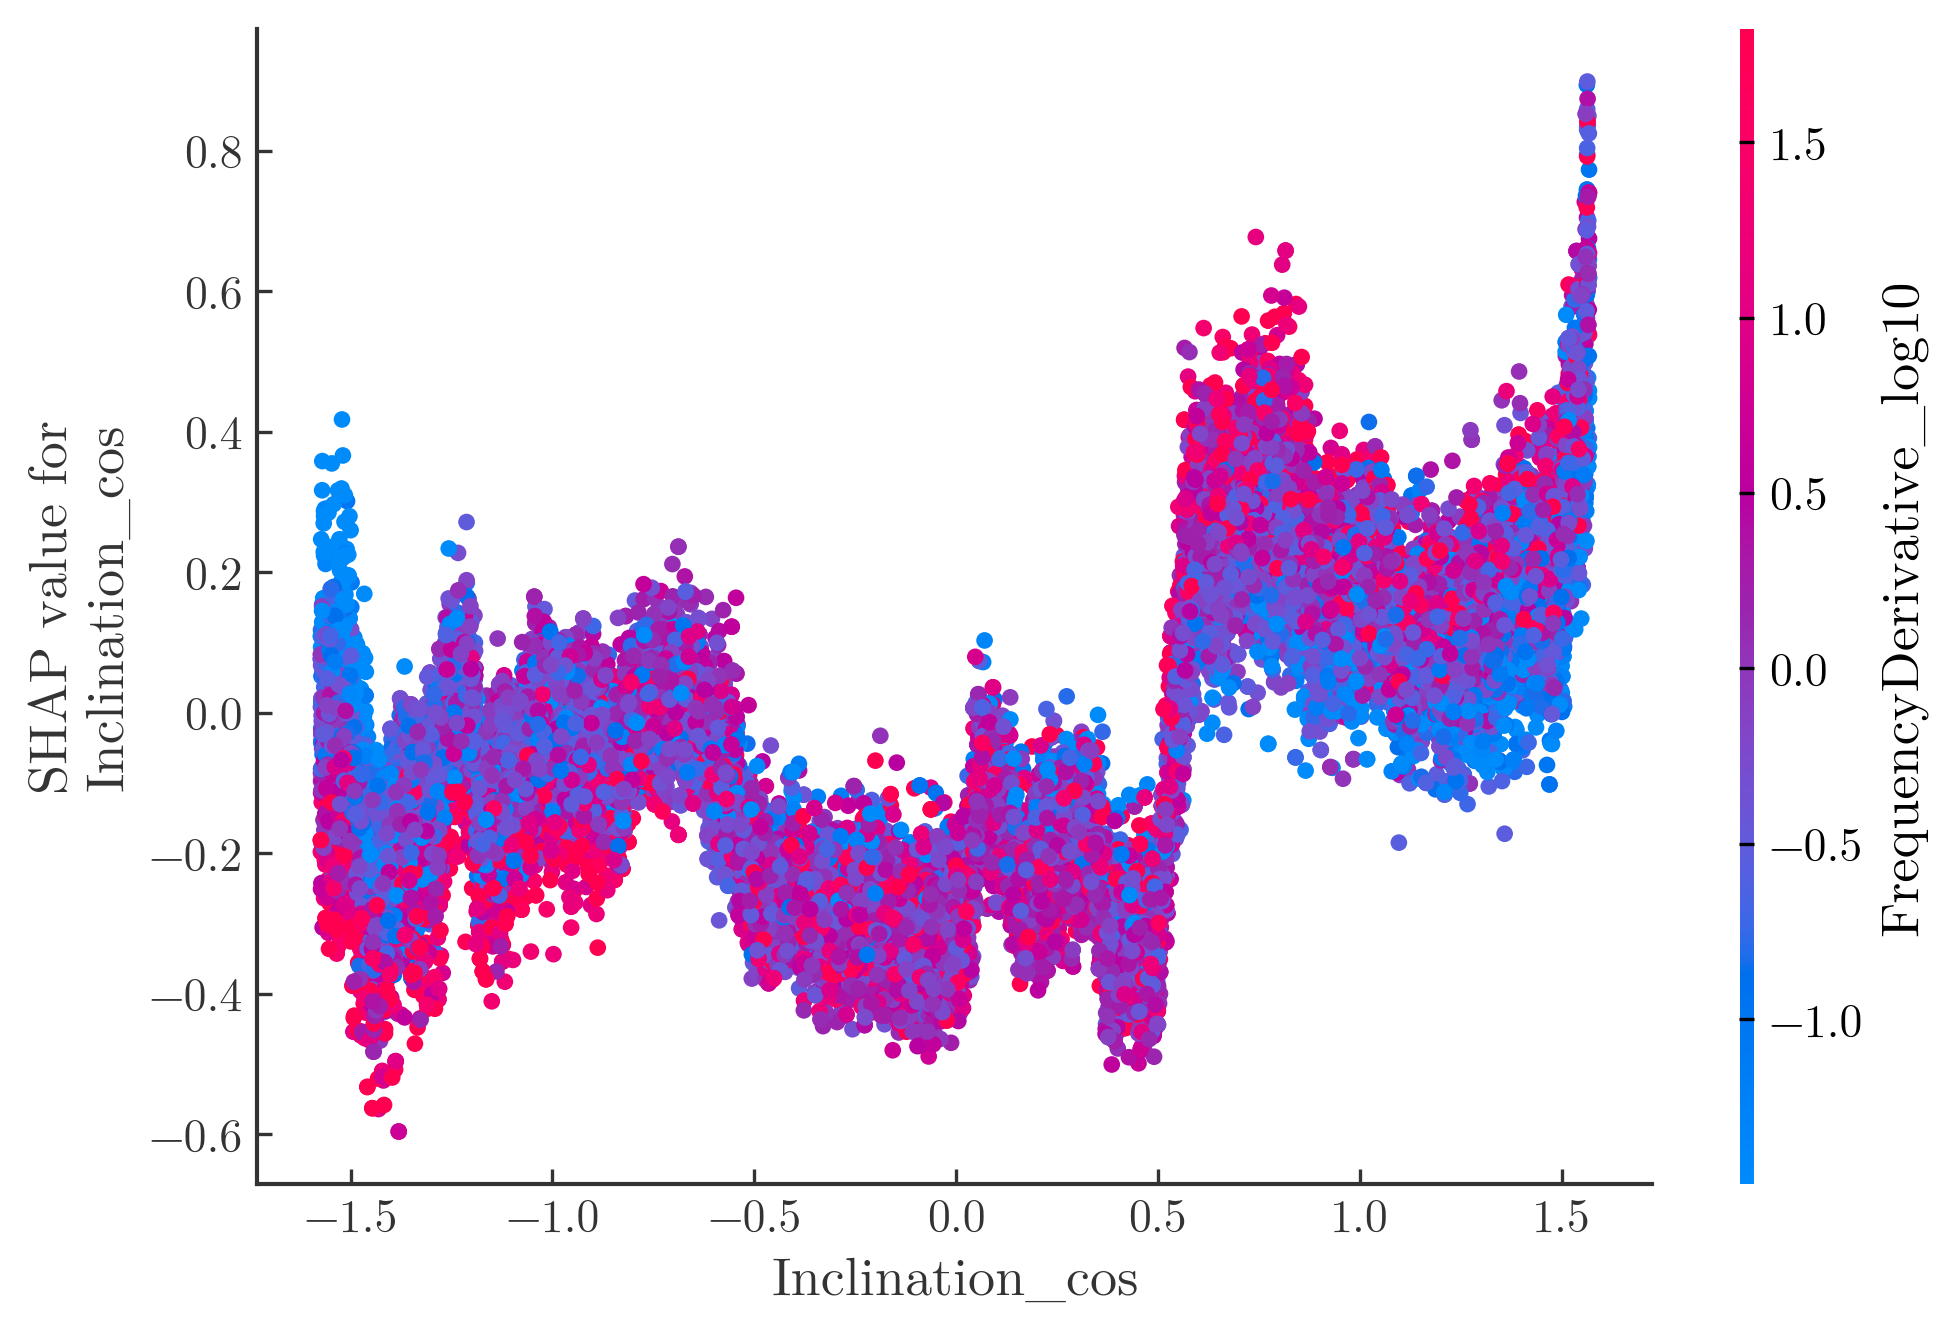

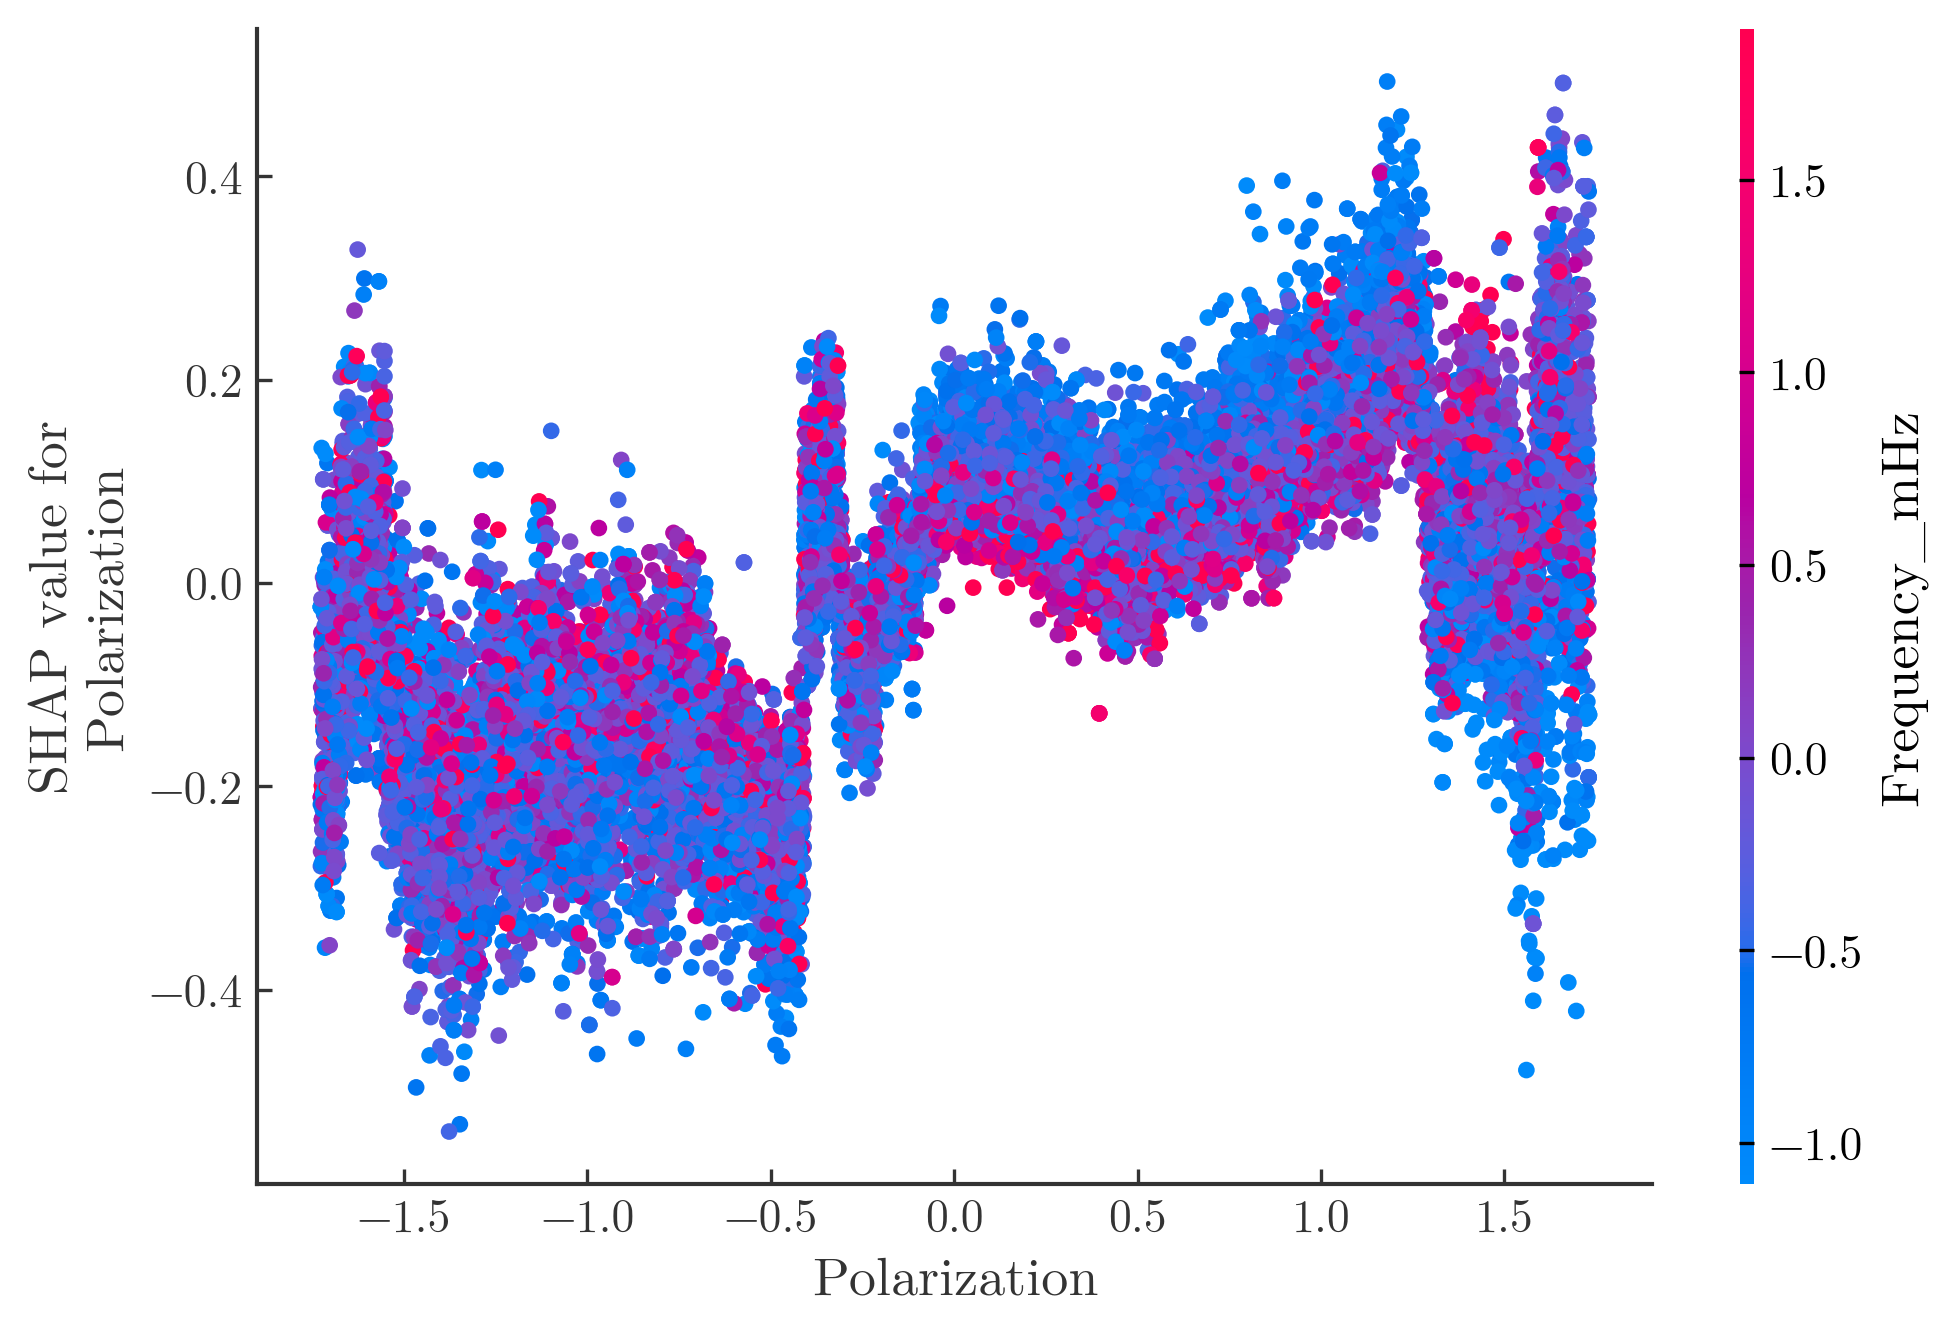

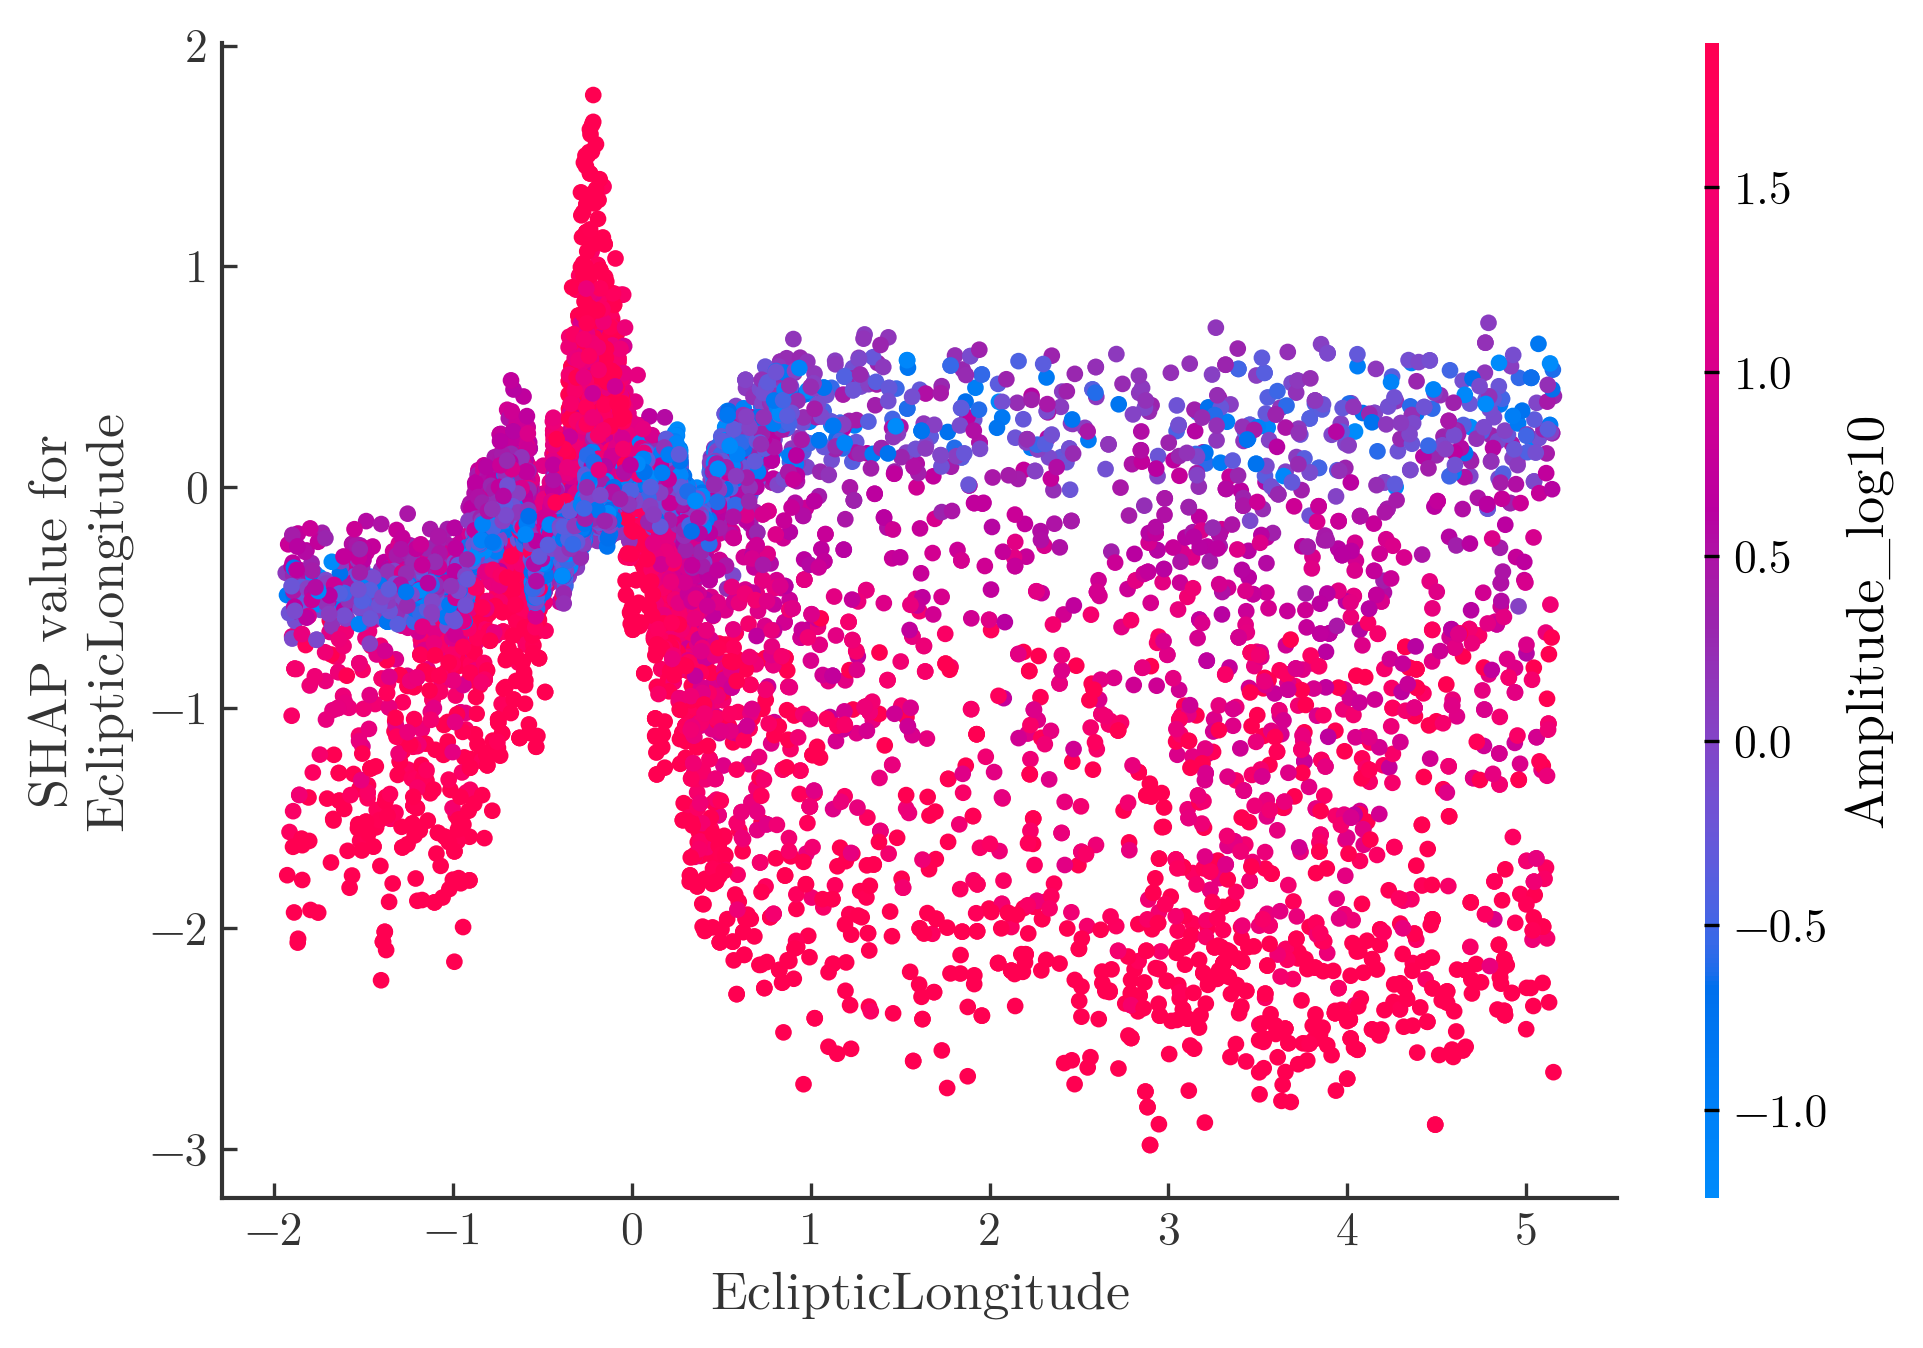

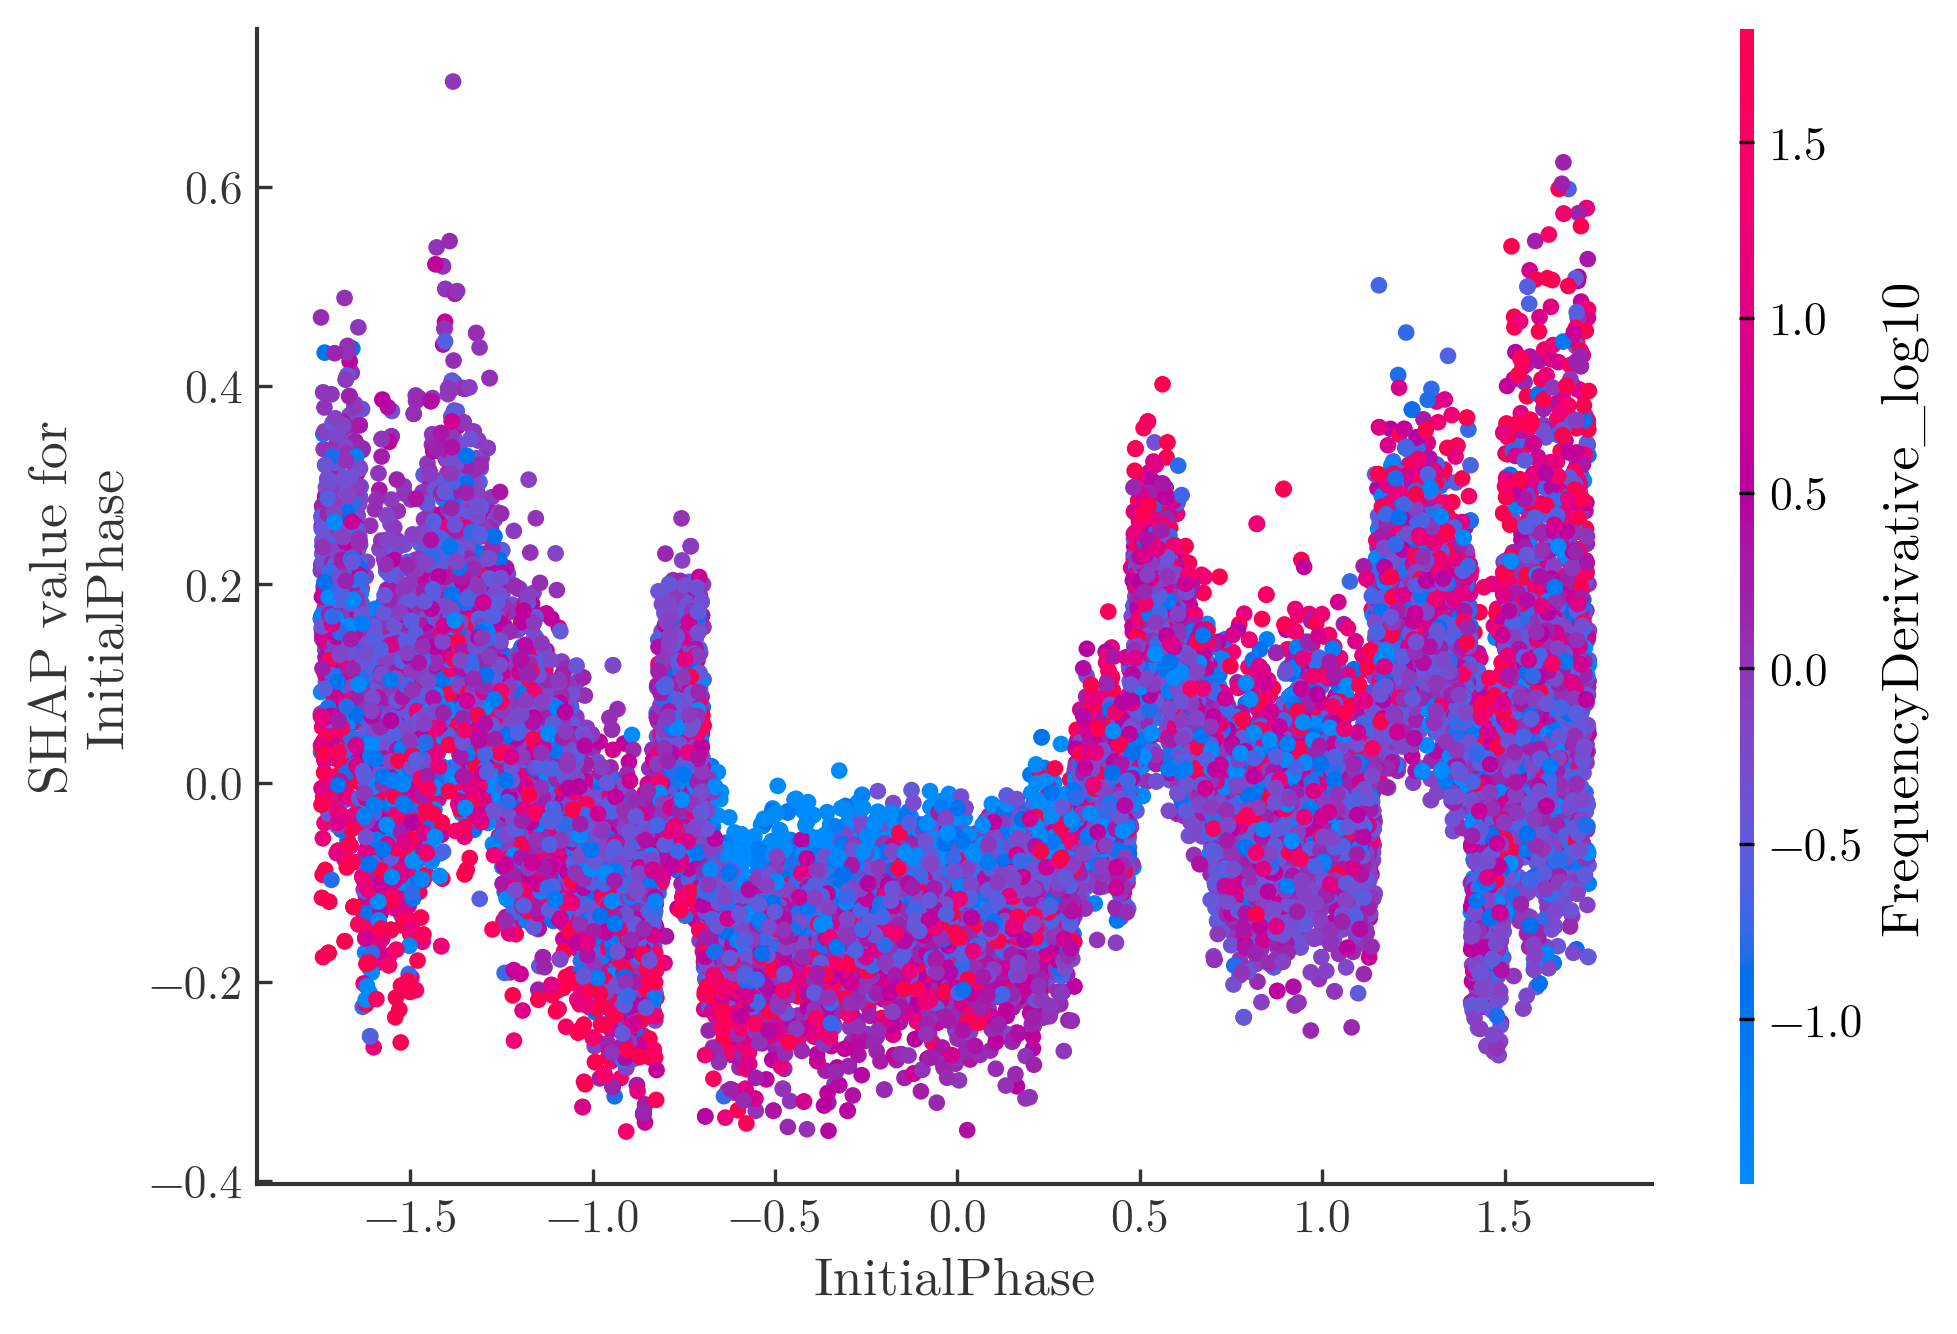

In [59]:
for name in X_val_df.columns:
    shap.dependence_plot(name, shap_values, X_val_df)




# Test catalog

In [36]:
cols = [
    'Frequency_Hz',
    'FrequencyDerivative',
    'EclipticLongitude_rad',
    'EclipticLatitude_rad',
    'Amplitude',
    'Inclination',
    'Polarization',
    'InitialPhase',
    'SNR'
]

df = pd.read_csv(
    '/Users/irwin/Documents/GitHub/lisa-ml/data/DWD_pop_Pmax025_nomag_detectedsample.txt',
    delim_whitespace=True,  
    header=None,            
    names=cols,           
    comment='#'           
)



/var/folders/rm/5j_dp79x6xx6xmxlxxs9k4y80000gn/T/ipykernel_11514/95115981.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [37]:
df['Eccentricity'] = 0
df['Class']       = 0

In [38]:
df

Frequency_Hz  FrequencyDerivative  EclipticLongitude_rad  \
0          0.004580         1.533247e-16              -0.359093   
1          0.006044         8.400668e-16              -0.960819   
2          0.002580         4.271284e-17               0.145311   
3          0.003603         6.012331e-17              -0.838355   
4          0.007248         9.784255e-16              -0.399504   
...             ...                  ...                    ...   
25494      0.002476         2.035869e-17              -0.850575   
25495      0.002554         1.996434e-17               0.169752   
25496      0.002373         1.044631e-17               0.409178   
25497      0.002477         2.415502e-17               0.570775   
25498      0.002478         1.166396e-17              -0.169462   

       EclipticLatitude_rad     Amplitude  Inclination  Polarization  \
0                 -1.799648  1.091590e-23     1.978701      5.165453   
1                 -2.687591  7.793981e-23     1.292703      4.338165   
2                 -1.313078  1.566901e-22     0.815948      4.744887   
3                 -2.300443  2.542905e-23     1.073548      5.963704   
4                 -1.801715  1.520023e-23     2.832615      1.043479   
...                     ...           ...          ...           ...   
25494             -2.267368  1.184541e-23     2.019263      2.786561   
25495             -1.503462  1.082833e-23     1.196430      4.021879   
25496             -1.368340  1.266833e-23     1.047695      0.088754   
25497             -1.245134  1.716615e-23     1.529687      1.100188   
25498             -1.585912  8.943883e-24     2.151404      4.216565   

       InitialPhase      SNR  Eccentricity  Class  
0          4.994016   14.221             0      0  
1          5.594561   87.212             0      0  
2          1.877037  161.564             0      0  
3          1.438876   30.007             0      0  
4          0.874307   41.367             0      0  
...             ...      ...           ...    ...  
25494      4.286631    7.230             0      0  
25495      6.167242    7.257             0      0  
25496      4.874231    7.125             0      0  
25497      4.497959    7.722             0      0  
25498      3.903573    7.366             0      0  

[25499 rows x 11 columns]

In [39]:
df['Frequency_mHz'] = df['Frequency_Hz'] * 1000
df['FrequencyDerivative_log10'] = np.log10(df['FrequencyDerivative'])
df['EclipticLatitude_sin'] = np.sin(df['EclipticLatitude_rad'])
df['Amplitude_log10'] = np.log10(df['Amplitude'])
df['Inclination_cos'] = np.cos(df['Inclination'])
df['EclipticLongitude'] = df['EclipticLongitude_rad']
cols_to_remove = ['Frequency_Hz', 'FrequencyDerivative', 'EclipticLatitude_rad', 'Amplitude', 'Inclination','EclipticLongitude_rad']
df.drop(columns=cols_to_remove, inplace=True)

In [40]:
selected_features = [
    'Frequency_mHz', 
    'Amplitude_log10', 
    'FrequencyDerivative_log10', 
    'SNR', 
    'Eccentricity',
    'EclipticLatitude_sin',
    'Inclination_cos',
    'Polarization',
    'EclipticLongitude',
    'InitialPhase'
]
X_test = df[selected_features]
X_test_scaled = scaler.transform(X_test)
y_test = df['Class']

In [41]:
y_test_pred = final_model.predict(X_test_scaled)

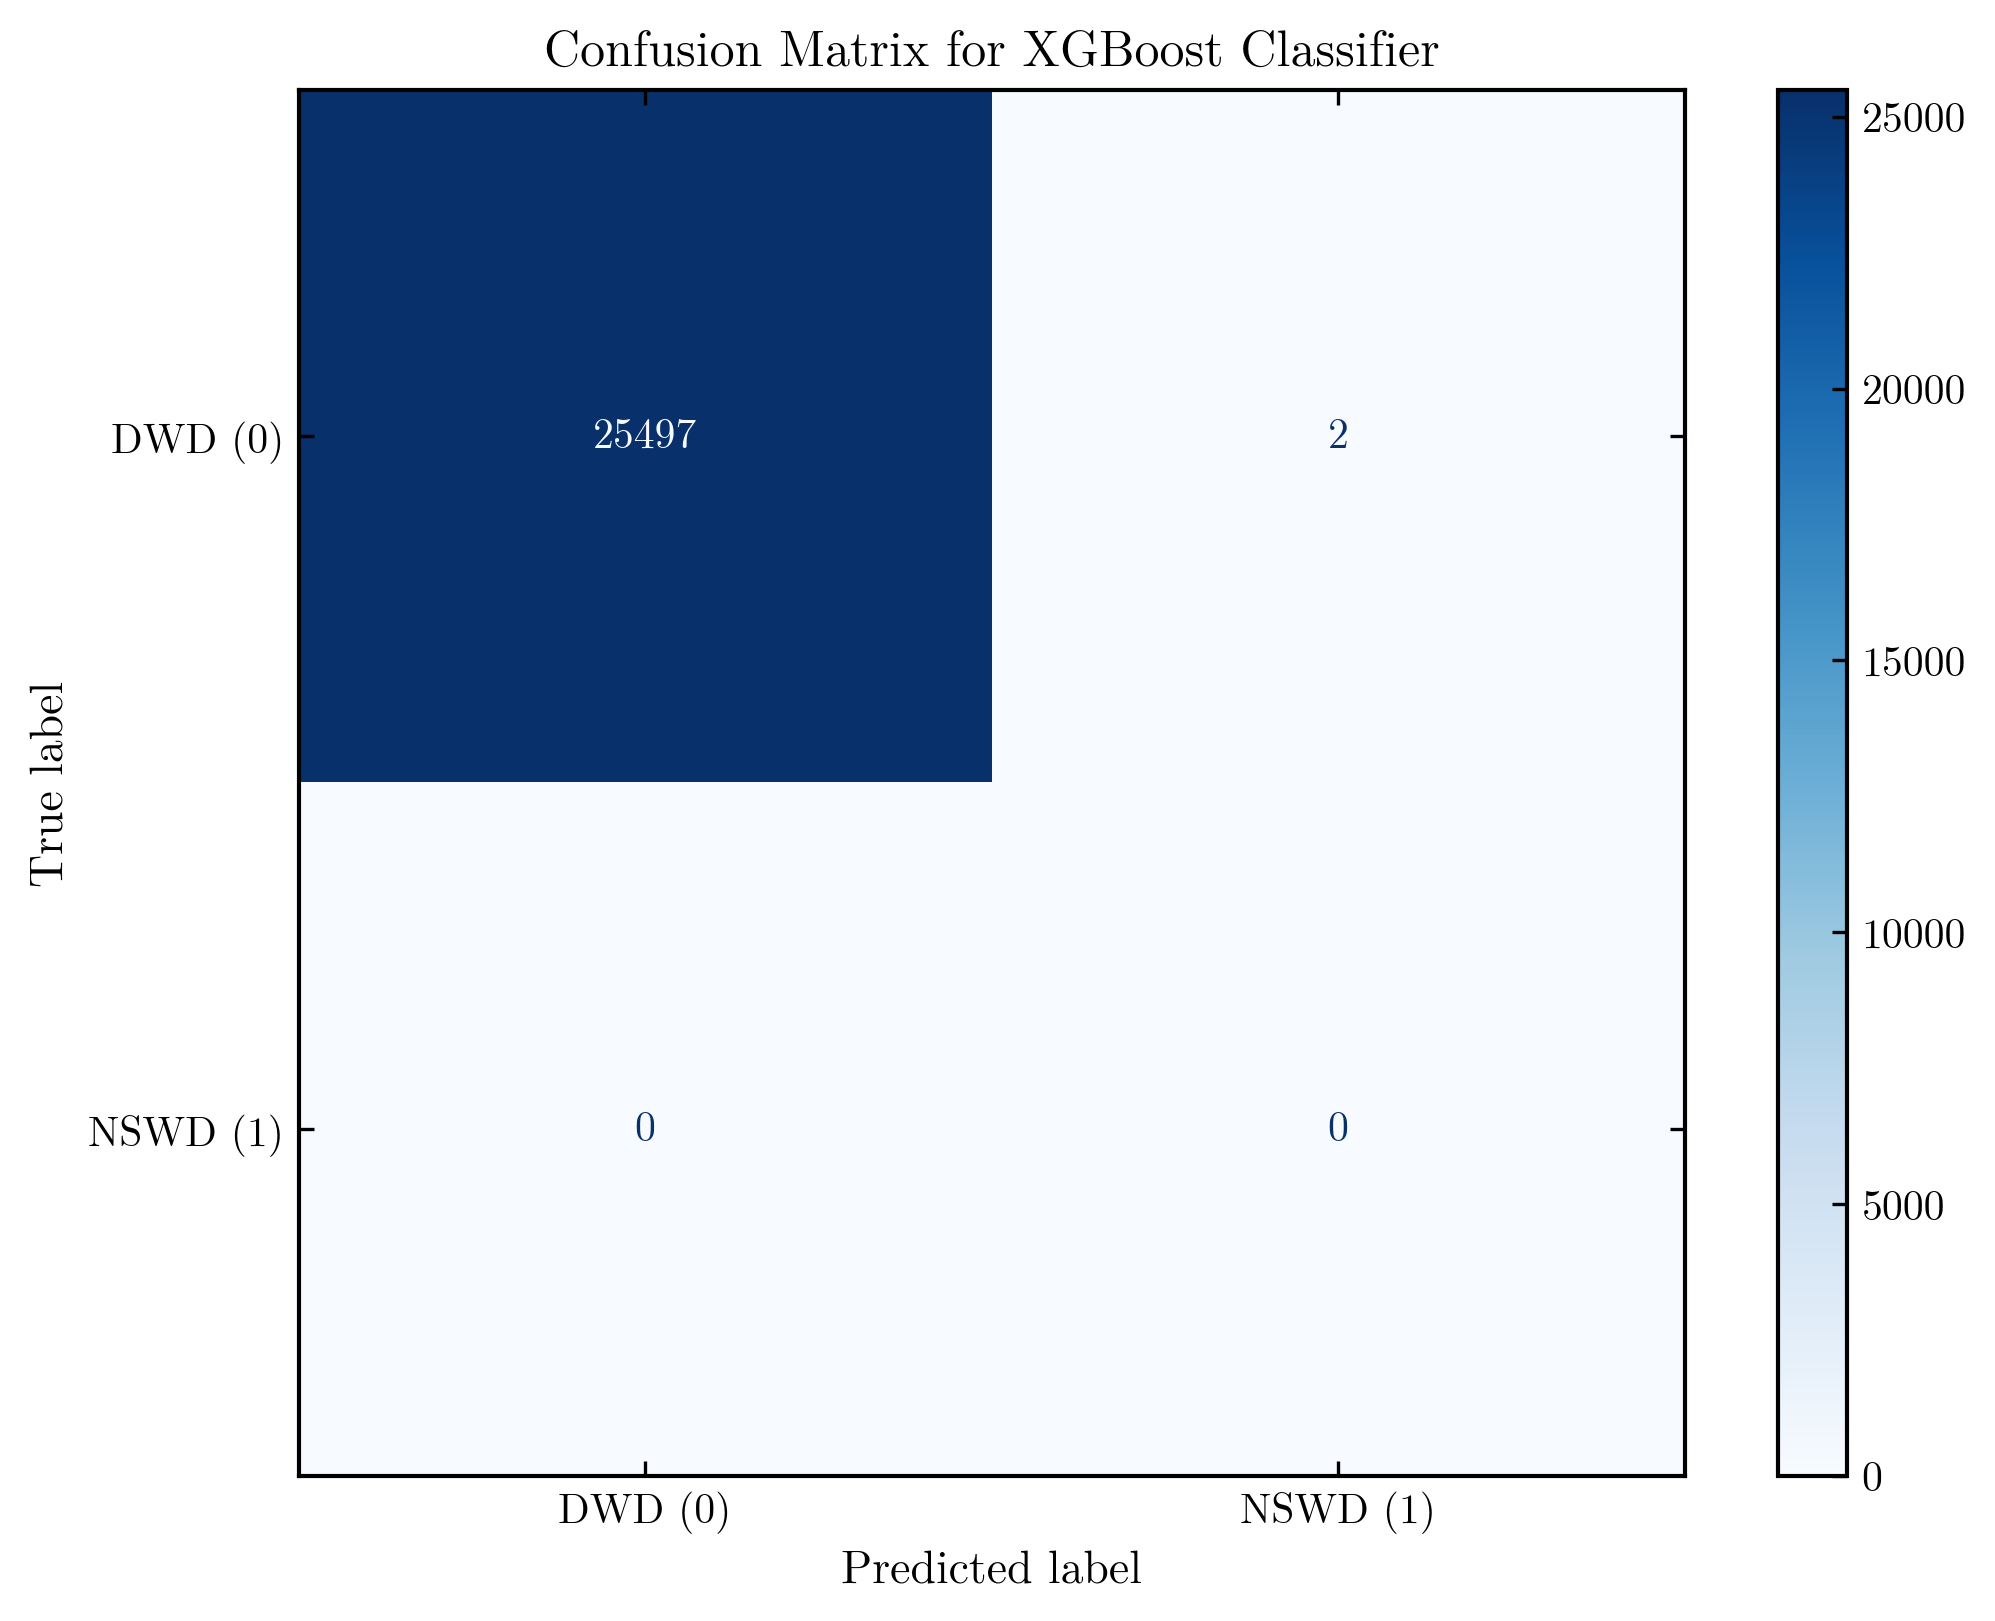

In [42]:
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DWD (0)', 'NSWD (1)'])

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for XGBoost Classifier")
plt.grid(False)
plt.show()

# Test catalog neither models

In [1]:
cols = [
    'Frequency_Hz',
    'FrequencyDerivative',
    'EclipticLongitude_rad',
    'EclipticLatitude_rad',
    'Amplitude',
    'Inclination',
    'Polarization',
    'InitialPhase',
    'SNR'
]

df = pd.read_csv(
    '/Users/irwin/Documents/GitHub/lisa-ml/data/DWD_pop_obs_default_correctVolume_inputLDC_snr_gt7.txt',
    delim_whitespace=True,  
    header=None,            
    names=cols,           
    comment='#'           
)

NameError: name 'pd' is not defined